# Setup

In [ ]:
#!pip install datasets sentence-transformers selfcheckgpt stanford_openie sentencepiece transformers
#!python -m spacy download en_core_web_sm

In [1]:
import pickle
import torch
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from tqdm import tqdm
from typing import List
from datasets import load_dataset
from selfcheckgpt.modeling_selfcheck import SelfCheckBERTScore
from sklearn.metrics import precision_recall_curve, auc
from sentence_transformers import SentenceTransformer
import warnings

# FutureWarning을 무시
warnings.simplefilter(action='ignore', category=FutureWarning)

# Ngram 정의

In [2]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

class NltkStopword:
    nltk.download("stopwords")
    stop_words = set(stopwords.words('english'))

class SelfCheckNgram:
    """
    SelfCheckGPT (Ngram variant): Checking LLM's text against its own sampled texts via ngram
    """
    def __init__(self, device=None):    
        if device is None:
            device = torch.device("cpu")
        self.device = device
        self.ngram_range = (1,1)

        print("SelfCheck-ngram initialized to device", device)

        """
        This function takes sentences (to be evaluated) with sampled passages (evidence), and return sent-level scores
        :param sentences: list[str] -- sentences to be evaluated, e.g., GPT text response split by spacy
        :param sampled_passages: list[list[str]] -- stochastically generated responses (split into sentences)
        :return sent_scores: list[float] -- sentence-level scores indicating hallucination probability
        """
    
    def predict(self, sentences: List[str], sampled_passages: List[List[str]]):
        scores = []
        vectorizer = CountVectorizer(analyzer='word', ngram_range=self.ngram_range)
        
        for sp in sentences:
            similarities = []
            for sp_ps in sampled_passages:         
                X = vectorizer.fit_transform([sp, sp_ps])
                cos_sim = cosine_similarity(X[0], X[1])
                similarities.append(cos_sim)
                
            # 평균 유사도 계산
            avg_max_similarity = np.mean(similarities)
            scores.append(avg_max_similarity)

        return scores

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jjae0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# HHEM 정의

In [3]:
from sentence_transformers import CsrossEncoder

class SelfCheckHHEM:
    """
    SelfCheckGPT (HHEM variant): Checking LLM's text against its own sampled texts via HHEM
    """
    def __init__(self, model_name='vectara/hallucination_evaluation_model', device=None):
        
        if device is None:
            device = torch.device("cpu")
        self.device = device
        self.model = CrossEncoder(model_name,device=device)

        print("SelfCheck-HHEM initialized to device", device)

    def predict(self, sentences: List[str], sampled_passages: List[List[str]]):
        """
        This function takes sentences (to be evaluated) with sampled passages (evidence), and return sent-level scores
        :param sentences: list[str] -- sentences to be evaluated, e.g., GPT text response split by spacy
        :param sampled_passages: list[list[str]] -- stochastically generated responses (split into sentences)
        :return sent_scores: list[float] -- sentence-level scores indicating hallucination probability
        """

        scores = [] 
        for sp in sentences:
            similarities = []
            for sp_ps in sampled_passages:
                sp.replace('\n', '')
                similarities.append(self.model.predict([sp, sp_ps]))
                
            avg_max_similarity = np.mean(similarities)
            scores.append(1- avg_max_similarity)
   
        return scores

# Sentence-Bert 정의

In [4]:
class SelfCheckSBERT:
    """
    SelfCheckGPT (SBERT variant): Checking LLM's text against its own sampled texts via Sentence-BERT
    """
    def __init__(self, model_name='paraphrase-MiniLM-L6-v2', device=None):
        self.model = SentenceTransformer(model_name)
        if device is None:
            device = torch.device("cpu")
        self.device = device
        self.model.to(self.device)
        print("SelfCheck-SBERT initialized to device", device)

    def cosine_similarity(self, embedding1, embedding2):
        return torch.nn.functional.cosine_similarity(embedding1, embedding2, dim=-1)

    def predict(self, sentences: List[str], sampled_passages: List[List[str]]):
        """
        This function takes sentences (to be evaluated) with sampled passages (evidence), and return sent-level scores
        :param sentences: list[str] -- sentences to be evaluated, e.g., GPT text response split by spacy
        :param sampled_passages: list[list[str]] -- stochastically generated responses (split into sentences)
        :return sent_scores: list[float] -- sentence-level scores indicating hallucination probability
        """
        # 응답 문장 임베딩 계산
        response_embeddings = self.model.encode(sentences, convert_to_tensor=True)

        # 샘플 문장 임베딩 계산
        sample_embeddings = [self.model.encode(sample, convert_to_tensor=True) for sample in sampled_passages]

        scores = []

        for response_embedding in response_embeddings:
            max_similarities = []
            for sample_embedding in sample_embeddings:
                # 각 샘플에서 가장 유사한 문장 찾기
                similarities = self.cosine_similarity(response_embedding.unsqueeze(0), sample_embedding)
                max_similarity = torch.max(similarities).item()
                max_similarities.append(max_similarity)

            # 평균 유사도 계산
            avg_max_similarity = np.mean(max_similarities)
            score = 1 - avg_max_similarity
            scores.append(score)

        return scores

In [5]:
import spacy
import bert_score
import numpy as np
import torch
from tqdm import tqdm
from typing import Dict, List, Set, Tuple, Union
from transformers import logging
from openie import StanfordOpenIE
logging.set_verbosity_error()

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM, AutoModel
from transformers import LongformerTokenizer, LongformerForMultipleChoice, LongformerForSequenceClassification
from transformers import DebertaV2ForSequenceClassification, DebertaV2Tokenizer
from openie import StanfordOpenIE

class NLIConfig:
    nli_model: str = "potsawee/deberta-v3-large-mnli"

class SelfCheckNLI:
    """
    SelfCheckGPT (NLI variant): Checking LLM's text against its own sampled texts via DeBERTa-v3 finetuned to Multi-NLI
    """
    def __init__(
        self,
        nli_model: str = None,
        device = None
    ):
        nli_model = nli_model if nli_model is not None else NLIConfig.nli_model
        self.tokenizer = DebertaV2Tokenizer.from_pretrained(nli_model)
        self.model = DebertaV2ForSequenceClassification.from_pretrained(nli_model)
        self.model.eval()
        if device is None:
            device = torch.device("cpu")
        self.model.to(device)
        self.device = device
        print("SelfCheck-NLI initialized to device", device)

    @torch.no_grad()
    def predict(
        self,
        sentences: List[str],
        sampled_passages: List[str],
    ):
        """
        This function takes sentences (to be evaluated) with sampled passages (evidence), and return sent-level scores
        :param sentences: list[str] -- sentences to be evaluated, e.g. GPT text response spilt by spacy
        :param sampled_passages: list[str] -- stochastically generated responses (without sentence splitting)
        :return sent_scores: sentence-level score which is P(condict|sentence, sample)
        note that we normalize the probability on "entailment" or "contradiction" classes only
        and the score is the probability of the "contradiction" class
        """
        num_sentences = len(sentences)
        num_samples = len(sampled_passages)
        scores = np.zeros((num_sentences, num_samples))
        for sent_i, sentence in enumerate(sentences):
            for sample_i, sample in enumerate(sampled_passages):
                inputs = self.tokenizer.batch_encode_plus(
                    batch_text_or_text_pairs=[(sentence, sample)],
                    add_special_tokens=True, padding="longest",
                    truncation=True, return_tensors="pt",
                    return_token_type_ids=True, return_attention_mask=True,
                )
                inputs = inputs.to(self.device)
                logits = self.model(**inputs).logits # neutral is already removed
                probs = torch.softmax(logits, dim=-1)
                prob_ = probs[0][1].item() # prob(contradiction)
                scores[sent_i, sample_i] = prob_
        scores_per_sentence = scores.mean(axis=-1)
        return scores_per_sentence
    

class SelfCheckOpenIE:
    def __init__(
        self,
        model: str = "bert-base-uncased",
        device = None
    ):
        self.nlp = spacy.load("en_core_web_sm")
        self.tokenizer = AutoTokenizer.from_pretrained(model)
        self.model = AutoModel.from_pretrained(model, torch_dtype="auto")
        self.model.eval()
        self.device = device if device else torch.device("cpu")
        self.model.to(device)
        self.properties = {
            'openie.affinity_probability_cap': 2 / 3,
        }
    
    def preprocess_text(self,text):
        doc = self.nlp(text)
        tokens = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct]
        sent = " ".join(tokens)
        return sent

    def extract_triples(self, text) -> List[tuple]:
        triples=[]
        with StanfordOpenIE(properties=self.properties) as client:
            for triple in client.annotate(text):
                #{'subject': 'city', 'relation': 'is in', 'object': 'Ćolia'}
                triple_tuple= (triple['subject'],triple['relation'],triple['object'])
                triples.append(triple_tuple)
        return triples
            
    def compute_similarity(self, triple1: tuple, triple2: tuple) -> float:
        vec1 = self.convert_to_embedding(triple1)
        vec2 = self.convert_to_embedding(triple2)
        similarity = torch.cosine_similarity(vec1, vec2, dim=0)
        return similarity.mean().item() 

    def convert_to_embedding(self, triple: tuple) -> torch.Tensor:
        inputs = self.tokenizer(' '.join(triple), return_tensors='pt').to(self.device)
        outputs = self.model(**inputs)
        return outputs.last_hidden_state.mean(dim=1)

    @torch.no_grad()
    def predict(
        self,
        sentences: List[str],
        sampled_passages: List[str],
        verbose: bool = True,
    ):
        # sentences=[self.preprocess_text(sent) for sent in sentences]
        # sampled_passages=[self.preprocess_text(sent) for sent in sampled_passages]

        sentences_len= len(sentences)
        samples_len=len(sampled_passages)

        similarities = [0] * sentences_len
        sentence_triples = [self.extract_triples(sent) for sent in sentences]

        for j in range(samples_len):
            passage_triples = self.extract_triples(sampled_passages[j])            
            for i in range(sentences_len):
                max_similarity = 0
                for s_triple in sentence_triples[i]:
                    for p_triple in passage_triples:
                        similarity = self.compute_similarity(s_triple, p_triple)
                        #print(f's_triple: {s_triple}, p_triple: {p_triple} | similarity: {similarity}')
                        if similarity > max_similarity:
                            max_similarity = similarity
                similarities[i] += max_similarity
                if verbose:
                    print(f'similarities[{i}] updated by sample[{j}]: {similarities[i]}')
            if verbose:
                print('----------------------------------------------------------------------------------------')
        #Normalize
        normalized_similarities= [1- similarity / samples_len for similarity in similarities]
        if verbose:
            print(f'Similarities: {normalized_similarities}')
        return normalized_similarities

# 실험 데이터 호출

In [6]:
# indices in WikiBio of the evaluated examples
ids = load_dataset("potsawee/wiki_bio_gpt3_hallucination")['evaluation']['wiki_bio_test_idx']
dataset = load_dataset("potsawee/wiki_bio_gpt3_hallucination")
dataset = dataset['evaluation']

# 데이터 개수 체크 -- 수정하며 확인

In [7]:
dataset_len= 230 # len(dataset)

In [8]:
label_mapping = {
    'accurate': 0.0,
    'minor_inaccurate': 0.5,
    'major_inaccurate': 1.0,
}

passage_human_label_detect_scores = {}
human_label_detect_False   = {}
human_label_detect_False_h = {}
human_label_detect_True    = {}

for i_ in range(dataset_len):
    dataset_i = dataset[i_]
    idx = dataset_i['wiki_bio_test_idx']
    raw_label = np.array([label_mapping[x] for x in dataset_i['annotation']])
    human_label_detect_False[idx] = (raw_label > 0.499).astype(np.int32).tolist()
    human_label_detect_True[idx]  = (raw_label < 0.499).astype(np.int32).tolist()
    average_score = np.mean(raw_label)
    passage_human_label_detect_scores[idx]= average_score
    if average_score < 0.99:
        human_label_detect_False_h[idx] = (raw_label > 0.99).astype(np.int32).tolist()

In [9]:
def unroll_pred(scores, indices):
    unrolled = []
    for idx in indices:
        unrolled.extend(scores[idx])
    return unrolled

def get_PR_with_human_labels(preds, human_labels, pos_label=1, oneminus_pred=False):
    indices = [k for k in human_labels.keys()]
    unroll_preds = unroll_pred(preds, indices)
    if oneminus_pred:
        unroll_preds = [1.0-x for x in unroll_preds]
    unroll_labels = unroll_pred(human_labels, indices)
    assert len(unroll_preds) == len(unroll_labels)
    print("len:", len(unroll_preds))
    P, R, thre = precision_recall_curve(unroll_labels, unroll_preds, pos_label=pos_label)
    return P, R

def print_AUC(P, R):
    print("AUC: {:.2f}".format(auc(R, P)*100))

# 모델 호출 (정의)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # set device to 'cuda' if GPU is available

selfcheck_bertscore = SelfCheckBERTScore(rescale_with_baseline=True)
selfcheck_sbert = SelfCheckSBERT()
selfcheck_nli = SelfCheckNLI(device=device) 
selfcheck_openie= SelfCheckOpenIE(device=device)
selfcheck_hhem = SelfCheckHHEM(device=device)
selfcheck_ngram = SelfCheckNgram(device=device)

SelfCheck-BERTScore initialized
SelfCheck-SBERT initialized to device cpu
SelfCheck-NLI initialized to device cpu
SelfCheck-HHEM initialized to device cpu
SelfCheck-ngram initialized to device cpu


# 계산 과정 (New)

In [11]:
import pickle
from tqdm import tqdm

bertscore_scores = {}
sbert_scores = {}
nli_scores = {}
openie_scores = {}
ngram_scores = {}
hhem_scores = {}

def save_scores_to_file(filename, scores):
    with open(filename, 'wb') as f:
        pickle.dump(scores, f)

for i_ in tqdm(range(dataset_len)):
    dataset_i = dataset[i_]
    idx = dataset_i['wiki_bio_test_idx']
    sentences = dataset_i['gpt3_sentences']
    sampled_passages = dataset_i['gpt3_text_samples'][:5]  # 테스트로 샘플 5개만 사용
    num_sentences = len(sentences)
    
    sent_scores_ngramscore = selfcheck_ngram.predict(
        sentences=sentences,
        sampled_passages=sampled_passages,
    )
    sent_scores_hhemscore = selfcheck_hhem.predict(
        sentences=sentences,
        sampled_passages=sampled_passages,
    )
    sent_scores_bertscore = selfcheck_bertscore.predict(
        sentences=sentences,
        sampled_passages=sampled_passages,
    )
    sent_scores_sbert = selfcheck_sbert.predict(
        sentences=sentences,
        sampled_passages=sampled_passages,
    )
    sent_scores_nli = selfcheck_nli.predict(
        sentences=sentences,
        sampled_passages=sampled_passages,
    )
    sent_scores_openie = selfcheck_openie.predict(
        sentences=sentences,
        sampled_passages=sampled_passages,
    )


    bertscore_scores[idx] = sent_scores_bertscore
    sbert_scores[idx] = sent_scores_sbert
    nli_scores[idx] = sent_scores_nli
    openie_scores[idx] = sent_scores_openie
    ngram_scores[idx] = sent_scores_ngramscore
    hhem_scores[idx] = sent_scores_hhemscore

    # 중간 결과 저장
    save_scores_to_file('bertscore_scores.pkl', bertscore_scores)
    save_scores_to_file('sbert_scores.pkl', sbert_scores)
    save_scores_to_file('nli_scores.pkl', nli_scores)
    save_scores_to_file('openie_scores.pkl', openie_scores)
    save_scores_to_file('ngram_scores.pkl', ngram_scores)
    save_scores_to_file('hhem_scores.pkl', hhem_scores)


  0%|          | 0/230 [00:00<?, ?it/s]

Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-df17e39a2e9b4c1b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-9a55b9ca9ec8472f.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-fa63d750524246f8.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp


  0%|          | 1/230 [25:57<99:05:19, 1557.73s/it]

similarities[8] updated by sample[4]: 3.1744791865348816
----------------------------------------------------------------------------------------
Similarities: [0.33177081942558284, 0.04166666269302366, 0.0958333373069763, 0.14895833730697627, 0.4296875, 0.24114583730697636, 1.0, 0.22031251192092893, 0.3651041626930237]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-506b246ba998432c.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e2875d313621424d.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_reso


  1%|          | 2/230 [43:12<79:09:41, 1249.92s/it]

similarities[6] updated by sample[4]: 2.3203124701976776
----------------------------------------------------------------------------------------
Similarities: [0.3671875, 0.3958333253860473, 0.2963541626930237, 0.0, 0.0, 0.4161458253860474, 0.5359375059604645]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-23f7d7dfe4d246c2.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-42a01562878d4f5d.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.Sta


  1%|▏         | 3/230 [1:15:09<98:02:08, 1554.75s/it]

similarities[8] updated by sample[4]: 2.6796875298023224
----------------------------------------------------------------------------------------
Similarities: [0.07343750000000004, 0.33281248807907104, 0.27604166269302366, 0.30625, 0.19687501192092893, 0.40520833730697636, 0.4411458373069763, 0.27447916269302364, 0.4640624940395355]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d9ca33c8a6114d5b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-3ee3436f720444ed.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.st


  2%|▏         | 4/230 [1:34:01<87:07:21, 1387.79s/it]

similarities[8] updated by sample[4]: 2.9505207538604736
----------------------------------------------------------------------------------------
Similarities: [0.1291666746139526, 0.30572916269302364, 0.17291667461395266, 0.3984375, 0.317187511920929, 0.31145832538604734, 0.34531251192092893, 0.3651041626930237, 0.40989584922790523]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-02802c6acecd4e0a.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-147fc63c2aad448b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.st

similarities[7] updated by sample[4]: 3.065104126930237
similarities[8] updated by sample[4]: 2.833333343267441
similarities[9] updated by sample[4]: 3.6614583134651184



  2%|▏         | 5/230 [1:54:31<83:10:21, 1330.76s/it]

similarities[10] updated by sample[4]: 2.7109374701976776
----------------------------------------------------------------------------------------
Similarities: [0.3375000059604645, 0.3723958253860473, 0.45416666269302364, 0.3677083373069763, 0.4614583373069763, 0.23854166269302368, 0.45833333730697634, 0.3869791746139526, 0.43333333134651186, 0.2677083373069763, 0.4578125059604645]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d44c14e6cac54fa6.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ab2d325555a846b9.props -preload openie
Starting serve

similarities[7] updated by sample[4]: 4.184895813465118
similarities[8] updated by sample[4]: 2.875
similarities[9] updated by sample[4]: 3.5546875



  3%|▎         | 6/230 [2:21:12<88:31:42, 1422.78s/it]

similarities[10] updated by sample[4]: 3.3125000596046448
----------------------------------------------------------------------------------------
Similarities: [0.11979167461395268, 0.15729166269302364, 1.0, 0.21354167461395268, 0.35208332538604736, 0.30156249999999996, 0.27083333730697634, 0.16302083730697636, 0.42500000000000004, 0.2890625, 0.337499988079071]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-973e7ffe04e74ede.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-92ad9d01772042b8.props -preload openie
Starting server with command: java 


  3%|▎         | 7/230 [2:45:42<89:05:04, 1438.14s/it]

similarities[8] updated by sample[4]: 2.755208373069763
----------------------------------------------------------------------------------------
Similarities: [0.243749988079071, 0.42500000000000004, 0.370312488079071, 0.4770833373069763, 0.38385416269302364, 0.37239583730697634, 0.4223958373069763, 0.31770833730697634, 0.4489583253860474]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-b817ebc550d54efe.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-69e3f607c2c840b3.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jja


  3%|▎         | 8/230 [2:59:01<76:08:47, 1234.81s/it]

similarities[6] updated by sample[4]: 2.5052083134651184
----------------------------------------------------------------------------------------
Similarities: [0.03385416269302366, 0.3526041567325592, 0.420312511920929, 0.28489583134651186, 0.2557291626930237, 0.4494791567325592, 0.49895833730697636]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-9961b8bf2ab746ef.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d12cabcd30014825.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-core


  4%|▍         | 9/230 [3:16:43<72:29:26, 1180.85s/it]

similarities[7] updated by sample[4]: 2.2526041865348816
----------------------------------------------------------------------------------------
Similarities: [0.08333333730697634, 0.448437488079071, 0.30156249999999996, 0.46875, 0.4260416626930237, 0.5, 1.0, 0.5494791626930237]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-fa3eb8a78a144f44.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e25909b710524978.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanfo


  4%|▍         | 10/230 [3:32:24<67:37:17, 1106.53s/it]

similarities[8] updated by sample[4]: 2.359375
----------------------------------------------------------------------------------------
Similarities: [0.17031248807907107, 0.06979166269302373, 0.2755208373069763, 0.34479166269302364, 0.3651041626930237, 0.36927081346511836, 0.4697916507720947, 0.5968750059604645, 0.528125]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-521a8293cbf44b7e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-86d71277c6d2424c.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_r


  5%|▍         | 11/230 [3:45:26<61:17:14, 1007.47s/it]

similarities[5] updated by sample[4]: 2.572916626930237
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.15989583730697632, 0.41302083730697636, 0.3296875, 0.2583333373069763, 0.48541667461395266]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-8978c5281a7e437e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-616875f5c21741d5.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.Stanfo

similarities[0] updated by sample[4]: 0
similarities[1] updated by sample[4]: 2.3984374701976776
similarities[2] updated by sample[4]: 2.9739582538604736
similarities[3] updated by sample[4]: 2.5703125298023224
similarities[4] updated by sample[4]: 2.955729156732559
similarities[5] updated by sample[4]: 4.002604156732559
similarities[6] updated by sample[4]: 4.091145813465118
similarities[7] updated by sample[4]: 3.8932291865348816
similarities[8] updated by sample[4]: 2.8984375298023224
similarities[9] updated by sample[4]: 3.622395873069763
similarities[10] updated by sample[4]: 3.8932291865348816



  5%|▌         | 12/230 [4:19:09<79:42:25, 1316.27s/it]

similarities[11] updated by sample[4]: 2.5703125298023224
----------------------------------------------------------------------------------------
Similarities: [1.0, 0.5203125059604645, 0.4052083492279053, 0.48593749403953557, 0.4088541686534881, 0.19947916865348814, 0.1817708373069763, 0.22135416269302366, 0.4203124940395355, 0.2755208253860474, 0.22135416269302366, 0.48593749403953557]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-f82a3a90dd414d44.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-15cc4c2763a74236.props -preload openie
Starting


  6%|▌         | 13/230 [4:26:46<63:39:00, 1055.95s/it]

similarities[6] updated by sample[4]: 2.8072916865348816
----------------------------------------------------------------------------------------
Similarities: [0.18854166269302364, 0.5041666746139526, 0.4046874940395355, 0.4609375, 0.3979166626930237, 0.4671874940395355, 0.43854166269302364]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-76ebeb785a4843ff.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-3ba23fadf3234d97.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3


  6%|▌         | 14/230 [5:01:15<81:42:36, 1361.83s/it]

similarities[9] updated by sample[4]: 2.989583373069763
----------------------------------------------------------------------------------------
Similarities: [0.11458332538604732, 0.23906249999999996, 0.4442708313465118, 0.4385416686534882, 1.0, 0.4010416746139527, 0.4536458194255829, 0.37812500000000004, 0.3989583373069763, 0.4020833253860474]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e0ddc017bb284804.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-c62ed97d926c47ee.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Use


  7%|▋         | 15/230 [5:12:18<68:45:38, 1151.34s/it]

similarities[7] updated by sample[4]: 3.5390624701976776
similarities[8] updated by sample[4]: 0
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.334375, 0.38593750000000004, 0.439062488079071, 1.0, 0.5171875, 0.4802083253860474, 0.2921875059604645, 1.0]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-61abb83af35c498c.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-cc88db9c82b848df.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources


  7%|▋         | 16/230 [5:29:49<66:38:06, 1120.97s/it]

similarities[6] updated by sample[4]: 2.1770833134651184
----------------------------------------------------------------------------------------
Similarities: [0.25104166269302364, 0.45677083134651186, 0.3864583253860474, 0.31354166269302364, 0.4416666746139526, 0.4385416567325592, 0.5645833373069763]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a769f93d825f42ee.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0dba0241a76a4e9b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-cor


  7%|▋         | 17/230 [5:39:03<56:14:14, 950.49s/it] 

similarities[5] updated by sample[4]: 3.0963541865348816
----------------------------------------------------------------------------------------
Similarities: [0.22187500000000004, 0.19218749999999996, 0.2651041686534882, 0.3984375, 0.4135416626930237, 0.3807291626930237]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-631a36a5f34f4ec7.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-87b4a8196db14eb6.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.


  8%|▊         | 18/230 [5:54:24<55:27:29, 941.74s/it]

similarities[4] updated by sample[4]: 2.502604156732559
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.11770832538604736, 0.40000001192092893, 0.5072916686534882, 0.4994791686534882]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-00dfdbe98706421d.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-664dbec05edf4da8.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPSer


  8%|▊         | 19/230 [6:09:50<54:55:10, 937.02s/it]

similarities[6] updated by sample[4]: 2.7213541865348816
----------------------------------------------------------------------------------------
Similarities: [0.039583337306976274, 0.22395833730697634, 0.3671875, 0.3552083373069763, 0.33489583730697636, 0.36927083134651184, 0.45572916269302366]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-4b1809ea5f9c44e8.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-35a60e1c78374b81.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4


  9%|▊         | 20/230 [6:29:40<59:04:55, 1012.84s/it]

similarities[9] updated by sample[4]: 2.7734375
----------------------------------------------------------------------------------------
Similarities: [0.05208333730697634, 0.16354166269302373, 1.0, 0.36250000000000004, 0.2781250059604645, 0.5161458373069763, 0.3609375, 0.4234375, 0.44427083730697636, 0.4453125]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-f3a460d5f20b4dad.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-73e548e9d5f94c81.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\st


  9%|▉         | 21/230 [6:52:26<64:57:42, 1118.96s/it]

similarities[9] updated by sample[4]: 2.481770873069763
----------------------------------------------------------------------------------------
Similarities: [1.0, 0.2880208492279053, 0.4197916626930237, 0.3734375, 0.38385416269302364, 0.4177083253860474, 0.5312499940395355, 0.5411458313465118, 1.0, 0.5036458253860474]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-f6d36a38b1194a4b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-658d538a881243b7.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_reso

similarities[7] updated by sample[3]: 2.2109375
similarities[8] updated by sample[3]: 2.4140625
similarities[9] updated by sample[3]: 2.4036458134651184
similarities[10] updated by sample[3]: 2.1406250596046448
similarities[11] updated by sample[3]: 2.3333333134651184
similarities[12] updated by sample[3]: 1.8437500298023224
----------------------------------------------------------------------------------------
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-80285746dbb1434b.props -preload openie
similarities[0] updated by sample[4]: 4.729166686534882
similarities[1] updated by sample[4]: 3.309895843267441
similarities[2] updated by sample[4]: 2.848958373069763
similarities[3] updated by sample[4]: 2.9687500596046448
similarities[4] updated by sample[4]: 3.2213541865348816
si


 10%|▉         | 22/230 [7:16:30<70:17:46, 1216.67s/it]

similarities[12] updated by sample[4]: 2.247395873069763
----------------------------------------------------------------------------------------
Similarities: [0.054166662693023726, 0.33802083134651184, 0.43020832538604736, 0.4062499880790711, 0.3557291626930237, 0.4828124940395355, 0.21822917461395264, 0.4223958373069763, 0.3755208373069763, 0.396875, 0.46718748807907107, 0.39531249999999996, 0.5505208253860474]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-79cc544c43b4434b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0ae380e062b542bd.prop


 10%|█         | 23/230 [7:25:31<58:17:22, 1013.73s/it]

similarities[4] updated by sample[4]: 3.3125
----------------------------------------------------------------------------------------
Similarities: [0.1364583253860474, 0.26406248807907107, 0.43906249403953557, 0.41927083730697634, 0.3375]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-191fc436e7994dc8.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-85ae31132f174e9f.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -po


 10%|█         | 24/230 [7:55:13<71:11:47, 1244.21s/it]

similarities[5] updated by sample[4]: 2.838541567325592
----------------------------------------------------------------------------------------
Similarities: [0.19218749999999996, 0.4036458313465119, 0.32916666269302364, 0.38177082538604734, 0.3770833373069763, 0.4322916865348816]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-b0749f2b0bfc4c87.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a647c964b63d4dfc.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stan


 11%|█         | 25/230 [8:25:22<80:30:31, 1413.81s/it]

similarities[8] updated by sample[4]: 3.1901041865348816
----------------------------------------------------------------------------------------
Similarities: [0.49218749403953554, 0.2833333373069763, 0.23697917461395268, 0.378124988079071, 0.45781249999999996, 0.4057291626930237, 0.4473958492279053, 0.4526041626930237, 0.36197916269302366]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e3655756030a4522.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-b798f2108f454930.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\j


 11%|█▏        | 26/230 [9:04:55<96:25:27, 1701.60s/it]

similarities[7] updated by sample[4]: 2.661458343267441
----------------------------------------------------------------------------------------
Similarities: [0.43541665673255925, 0.4020833253860474, 0.47760416269302364, 0.27135416865348816, 0.346874988079071, 0.45781249999999996, 0.5276041686534881, 0.4677083313465118]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-51526978eb0d4de3.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-9f6009075b614601.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_res


 12%|█▏        | 27/230 [10:11:03<134:17:38, 2381.57s/it]

similarities[8] updated by sample[4]: 3.2760416865348816
----------------------------------------------------------------------------------------
Similarities: [1.0, 0.07916666269302364, 0.24270832538604736, 0.2869791746139526, 0.4927083313465118, 0.3151041567325592, 0.32083332538604736, 0.24895832538604734, 0.34479166269302364]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6f7a8edaeea04cb7.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0d8f5b80ac754ea2.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfor


 12%|█▏        | 28/230 [10:37:39<120:24:47, 2145.98s/it]

similarities[8] updated by sample[4]: 2.7109375298023224
----------------------------------------------------------------------------------------
Similarities: [0.09843749999999996, 0.32656248807907107, 0.33333333730697634, 0.32552083730697634, 0.30625, 0.31718749999999996, 0.29374999999999996, 0.3416666626930237, 0.4578124940395355]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2b8783acdf1740e3.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0acc683b941b4aa4.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.st

similarities[7] updated by sample[4]: 4.062500059604645
similarities[8] updated by sample[4]: 3.3437499403953552
similarities[9] updated by sample[4]: 3.385416626930237



 13%|█▎        | 29/230 [11:03:05<109:25:30, 1959.85s/it]

similarities[10] updated by sample[4]: 2.6796874403953552
----------------------------------------------------------------------------------------
Similarities: [0.18437499999999996, 0.3177083253860473, 0.2755208373069763, 0.350000011920929, 0.15885416269302366, 0.2828125, 0.17500001192092896, 0.1874999880790711, 0.33125001192092896, 0.3229166746139527, 0.46406251192092896]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-bbc8c6f0bff94f83.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-64be726a40454f8f.props -preload openie
Starting server with co


 13%|█▎        | 30/230 [11:19:35<92:42:26, 1668.73s/it] 

similarities[7] updated by sample[4]: 2.9296875596046448
----------------------------------------------------------------------------------------
Similarities: [1.0, 0.0390625, 0.23489583730697627, 0.28385415077209475, 0.2052083373069763, 0.46354166269302366, 0.3296875, 0.4140624880790711]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0630638e0bc94130.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-06a5a23d7d8d405c.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* 


 13%|█▎        | 31/230 [11:31:37<76:32:36, 1384.71s/it]

similarities[7] updated by sample[4]: 2.513020843267441
----------------------------------------------------------------------------------------
Similarities: [0.3098958432674408, 0.2869791746139526, 0.4098958253860474, 0.4958333373069763, 0.4328125059604645, 0.41822916865348814, 0.38072916865348816, 0.4973958313465119]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6822d287b6db4196.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6a4605dc8e614a86.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_reso


 14%|█▍        | 32/230 [12:13:04<94:21:36, 1715.64s/it]

similarities[9] updated by sample[4]: 2.8671875
----------------------------------------------------------------------------------------
Similarities: [0.20416667461395266, 0.2338541507720947, 0.2791666626930237, 0.3447916567325592, 0.19687500000000002, 0.2963541626930237, 0.38958332538604734, 0.3848958373069763, 0.3708333432674408, 0.42656249999999996]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-f8d763e7c06f4841.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-31c2042589c34099.props -preload openie
Starting server with command: java -Xmx8G -c


 14%|█▍        | 33/230 [12:40:48<93:01:44, 1700.02s/it]

similarities[7] updated by sample[4]: 3.1666666865348816
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.4005208373069763, 0.33854166269302366, 0.37604166269302364, 0.44947916865348814, 0.40729167461395266, 0.36458333730697634, 0.3666666626930237]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-4348b07133754f4a.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d2c9c1bdb1b64195.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanf


 15%|█▍        | 34/230 [13:10:51<94:14:38, 1731.01s/it]

similarities[4] updated by sample[4]: 3.203125
----------------------------------------------------------------------------------------
Similarities: [0.18437499999999996, 0.40572915673255916, 0.4604166626930237, 0.37083331942558284, 0.359375]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-5a41b5329cfa4dfa.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-783963c42e334e4c.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer

similarities[8] updated by sample[4]: 4.0390625
similarities[9] updated by sample[4]: 3.263020873069763



 15%|█▌        | 35/230 [13:49:04<102:53:51, 1899.65s/it]

similarities[10] updated by sample[4]: 3.205729156732559
----------------------------------------------------------------------------------------
Similarities: [0.1932291626930237, 0.20468750000000002, 0.44583334326744084, 0.307812488079071, 0.325000011920929, 0.5020833253860474, 0.41874999999999996, 0.35156249403953554, 0.19218749999999996, 0.3473958253860474, 0.3588541686534882]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2e1be2a538c74e68.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ca7edae86c2346d3.props -preload openie
Starting server 

similarities[0] updated by sample[4]: 2.2942708134651184
similarities[1] updated by sample[4]: 2.8255208134651184
similarities[2] updated by sample[4]: 3.0833333134651184
similarities[3] updated by sample[4]: 3.7890625
similarities[4] updated by sample[4]: 3.044270843267441
similarities[5] updated by sample[4]: 2.7890625298023224
similarities[6] updated by sample[4]: 2.8776041865348816
similarities[7] updated by sample[4]: 3.169270932674408
similarities[8] updated by sample[4]: 3.0104166865348816
similarities[9] updated by sample[4]: 3.1197916865348816
similarities[10] updated by sample[4]: 2.4557291865348816



 16%|█▌        | 36/230 [14:17:57<99:40:36, 1849.67s/it] 

similarities[11] updated by sample[4]: 2.5546875
----------------------------------------------------------------------------------------
Similarities: [0.5411458373069763, 0.43489583730697634, 0.3833333373069763, 0.2421875, 0.3911458313465118, 0.4421874940395355, 0.42447916269302366, 0.36614581346511843, 0.3979166626930237, 0.37604166269302364, 0.5088541626930236, 0.48906249999999996]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-af314ca619164334.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-14ac6408f8da4691.props -preload openie
Starting se

similarities[7] updated by sample[4]: 2.955729126930237
similarities[8] updated by sample[4]: 3.268229126930237
similarities[9] updated by sample[4]: 3.3567708134651184



 16%|█▌        | 37/230 [14:56:45<106:50:53, 1993.02s/it]

similarities[10] updated by sample[4]: 3.1302083134651184
----------------------------------------------------------------------------------------
Similarities: [1.0, 0.3088541626930237, 0.4140625, 0.3765625, 0.354687488079071, 0.42135415673255916, 0.5161458373069763, 0.4088541746139527, 0.3463541746139527, 0.3286458373069763, 0.37395833730697636]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-1f42e0893db543e0.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-32d9f19506604e04.props -preload openie
Starting server with command: java -Xmx8G -cp C:\U


 17%|█▋        | 38/230 [15:19:35<96:19:17, 1806.03s/it] 

similarities[8] updated by sample[4]: 3.505208373069763
----------------------------------------------------------------------------------------
Similarities: [0.2187499880790711, 0.24270833730697627, 0.49583331942558284, 0.43125001192092893, 0.23281249999999998, 0.31562500000000004, 0.3166666746139526, 0.37968749999999996, 0.2989583253860474]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a97879e118f14ac0.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a6bd9cf07ec947d9.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users


 17%|█▋        | 39/230 [15:33:09<80:02:09, 1508.53s/it]

similarities[6] updated by sample[4]: 2.3203125
----------------------------------------------------------------------------------------
Similarities: [0.1932291626930237, 0.16458332538604736, 0.3973958313465118, 0.3177083253860473, 0.4562500059604645, 0.30156249999999996, 0.5359375]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-fdd4d8772dbe4149.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ca7f882077bc4983.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.st


 17%|█▋        | 40/230 [16:16:26<96:50:46, 1834.98s/it]

similarities[6] updated by sample[4]: 3.859375
----------------------------------------------------------------------------------------
Similarities: [0.19947916269302368, 0.21562499999999996, 0.35312499403953557, 0.3307291746139527, 0.4286458313465118, 0.5171875, 0.22812500000000002]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-c2ff65f47dbf4c9a.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-3d68d1dd72374e9b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.s


 18%|█▊        | 41/230 [16:27:22<77:46:25, 1481.40s/it]

similarities[4] updated by sample[4]: 3.677083343267441
----------------------------------------------------------------------------------------
Similarities: [0.0, 1.0, 0.22916666269302366, 0.49114582538604734, 0.2645833313465118]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a28f655a19de4822.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-785b0844159d4770.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 


 18%|█▊        | 42/230 [16:47:45<73:18:55, 1403.91s/it]

similarities[9] updated by sample[4]: 2.5078125298023224
----------------------------------------------------------------------------------------
Similarities: [0.22864582538604739, 0.39843749403953554, 0.3880208313465119, 0.4572916567325592, 0.5328125059604645, 0.44531249403953554, 0.40624999403953554, 0.4437499940395355, 0.39843749403953554, 0.4984374940395355]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6cdc215601044992.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-24e3abde8e51457f.props -preload openie
Starting server with command: java


 19%|█▊        | 43/230 [17:05:05<67:14:44, 1294.57s/it]

similarities[8] updated by sample[4]: 2.9166666865348816
----------------------------------------------------------------------------------------
Similarities: [0.20989583730697636, 0.39322916269302366, 0.5505208313465119, 0.4192708313465119, 0.26093751192092896, 0.3734375, 0.47343748807907104, 0.4343750059604645, 0.41666666269302366]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-c3d9d7773bac48fe.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2075b77ee1174f56.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.s


 19%|█▉        | 44/230 [17:32:00<71:51:22, 1390.77s/it]

similarities[6] updated by sample[4]: 2.7343749403953552
----------------------------------------------------------------------------------------
Similarities: [0.2531250059604645, 0.4635416746139527, 0.303125, 0.421875, 0.375, 0.3557291746139526, 0.4531250119209289]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a0cd791f00a143ee.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-4d0dca2b23334a99.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeli


 20%|█▉        | 45/230 [17:45:19<62:20:47, 1213.23s/it]

similarities[10] updated by sample[4]: 3.023437410593033
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.0, 0.39166666269302364, 0.44374998807907107, 0.0, 0.4177083373069763, 0.3338541626930237, 0.43229166269302366, 0.3572916746139526, 0.32499999999999996, 0.39531251788139343]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-1468416c2b7d4af8.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0766b67a0a814287.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae


 20%|██        | 46/230 [17:56:15<53:28:31, 1046.26s/it]

similarities[7] updated by sample[4]: 2.286458343267441
----------------------------------------------------------------------------------------
Similarities: [0.296875, 0.49895833730697636, 0.4541666686534882, 0.4822916626930237, 0.5203125, 0.5489583313465118, 0.5531250059604644, 0.5427083313465119]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-f9cead721a96435a.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2957bedc814c4577.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-coren


 20%|██        | 47/230 [18:13:43<53:12:33, 1046.74s/it]

similarities[8] updated by sample[4]: 3.2135416865348816
----------------------------------------------------------------------------------------
Similarities: [1.0, 0.1697916626930237, 0.2963541626930237, 0.3145833373069763, 0.20468750000000002, 0.37812501192092896, 0.31927082538604734, 0.3552083373069763, 0.3572916626930237]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-550195d2d9d84d29.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-215f7232eb374dc5.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordn


 21%|██        | 48/230 [18:17:06<40:06:48, 793.45s/it] 

similarities[2] updated by sample[4]: 3.643229216337204
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.34479166269302364, 0.27135415673255925]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e512a6cacba5463e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ded5625fdbd84c1e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5


 21%|██▏       | 49/230 [18:29:36<39:14:37, 780.54s/it]

similarities[7] updated by sample[4]: 3.5911458134651184
----------------------------------------------------------------------------------------
Similarities: [1.0, 0.08177083730697632, 0.41093748807907104, 0.38749999999999996, 0.39791667461395264, 0.3046875, 0.47395833730697634, 0.2817708373069763]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e97c64091da649a7.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-3cad89188bc7452f.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-coren


 22%|██▏       | 50/230 [19:08:55<62:42:21, 1254.12s/it]

similarities[8] updated by sample[4]: 3.0520833134651184
----------------------------------------------------------------------------------------
Similarities: [0.15260416269302368, 0.271875011920929, 0.2791666626930237, 0.3333333253860473, 0.4296875119209289, 0.40937500000000004, 0.3911458373069763, 0.3828125, 0.38958333730697636]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-8975d2c3fa17413f.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-76274bc38b7d4ab9.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stan


 22%|██▏       | 51/230 [19:30:24<62:52:16, 1264.45s/it]

similarities[5] updated by sample[4]: 4.054687440395355
----------------------------------------------------------------------------------------
Similarities: [0.12864583730697632, 0.389062511920929, 0.46770833730697636, 0.1114583373069763, 0.3046875, 0.18906251192092893]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-387220b29e7946b3.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-51f297626926472c.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.p


 23%|██▎       | 52/230 [19:45:00<56:45:49, 1148.03s/it]

similarities[5] updated by sample[4]: 2.494791626930237
----------------------------------------------------------------------------------------
Similarities: [0.05885416269302368, 0.4223958373069763, 0.4244791686534881, 0.53125, 0.4895833313465119, 0.5010416746139527]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-4ca8f7167f85400e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6c2fc3f683d94407.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipe


 23%|██▎       | 53/230 [19:49:23<43:23:12, 882.44s/it] 

similarities[4] updated by sample[4]: 3.4921875298023224
----------------------------------------------------------------------------------------
Similarities: [0.2177083313465118, 0.10624999999999996, 0.4046875, 0.11041666269302364, 0.3015624940395355]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-9440fe40491746a2.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d378741a9b874723.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCor


 23%|██▎       | 54/230 [20:11:36<49:44:49, 1017.55s/it]

similarities[7] updated by sample[4]: 2.0703124701976776
----------------------------------------------------------------------------------------
Similarities: [0.27760416865348814, 0.3838541567325592, 0.43072916269302364, 0.3932291686534881, 0.5015625059604645, 0.4651041746139526, 0.4270833313465119, 0.5859375059604645]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a90b2efea39c40d1.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-8372f78a56454639.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_res


 24%|██▍       | 55/230 [20:33:44<53:59:19, 1110.63s/it]

similarities[5] updated by sample[4]: 3.1328124403953552
----------------------------------------------------------------------------------------
Similarities: [0.20364583134651182, 0.22812500000000002, 0.06979166269302373, 0.3447916507720947, 0.4802083253860474, 0.373437511920929]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-25afd5a285af4cdd.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a970be56692148d2.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stan


 24%|██▍       | 56/230 [20:59:18<59:49:09, 1237.64s/it]

similarities[9] updated by sample[4]: 2.7395833134651184
----------------------------------------------------------------------------------------
Similarities: [0.07135416269302364, 0.4088541686534881, 0.3963541626930237, 0.31770833730697634, 0.5026041626930237, 0.5010416805744171, 0.4791666746139527, 0.41510417461395266, 0.4145833373069763, 0.45208333730697636]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-dcd2d5110369414d.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2679565ffac144c1.props -preload openie
Starting server with command: java 


 25%|██▍       | 57/230 [21:23:16<62:22:19, 1297.91s/it]

similarities[7] updated by sample[4]: 2.5755208134651184
----------------------------------------------------------------------------------------
Similarities: [0.38281249403953554, 0.3421874940395355, 0.4614583373069763, 0.38333332538604736, 0.44843748211860657, 0.45260417461395264, 0.46510416865348814, 0.4848958373069763]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-08a24af0f8af4ab1.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-dad2bef052bd42e1.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_


 25%|██▌       | 58/230 [22:03:38<78:07:00, 1635.00s/it]

similarities[9] updated by sample[4]: 3.997395873069763
----------------------------------------------------------------------------------------
Similarities: [0.19635416269302364, 0.08125000000000004, 0.3020833253860473, 0.48593749403953557, 0.475000011920929, 0.5822916686534881, 0.4463541686534882, 0.26458332538604734, 0.3437500119209289, 0.20052082538604732]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e7df599c55d34ba6.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-1255a9a4542b4c74.props -preload openie
Starting server with command: java -


 26%|██▌       | 59/230 [22:43:02<88:03:27, 1853.84s/it]

similarities[7] updated by sample[4]: 3.1145833134651184
----------------------------------------------------------------------------------------
Similarities: [0.2755208373069763, 0.42552083134651186, 0.389062511920929, 0.30156249999999996, 0.4343750059604645, 0.40625, 0.3651041746139526, 0.3770833373069763]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-97cb07f60acf4b89.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-36bef724131743ee.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanf


 26%|██▌       | 60/230 [22:57:19<73:24:37, 1554.58s/it]

similarities[9] updated by sample[4]: 3.2239583134651184
----------------------------------------------------------------------------------------
Similarities: [0.32708333730697636, 0.3989583313465118, 0.424999988079071, 0.365625, 0.5052083253860473, 0.49687499999999996, 0.36614582538604734, 0.35520833134651186, 0.3614583373069763, 0.3552083373069763]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-4a9ae362784a43b0.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-88b6206552544148.props -preload openie
Starting server with command: java -Xmx8G -cp 


 27%|██▋       | 61/230 [23:09:25<61:18:59, 1306.15s/it]

similarities[5] updated by sample[4]: 2.533854156732559
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.41770833134651186, 0.34479166269302364, 0.40781249403953557, 0.328125, 0.4932291686534882]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-86bf720ae9da4dc2.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-98be0f090f2c420a.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.Stanfor


 27%|██▋       | 62/230 [23:22:01<53:14:49, 1141.01s/it]

similarities[7] updated by sample[4]: 2.5572916865348816
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.36041666269302364, 0.22395832538604732, 0.3338541746139526, 0.2640625, 0.2421875, 0.37760416269302366, 0.4885416626930237]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d440aa5c78f84503.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-520ed0f542a94342.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* 


 27%|██▋       | 63/230 [23:37:35<50:03:01, 1078.93s/it]

similarities[5] updated by sample[4]: 3.520833373069763
----------------------------------------------------------------------------------------
Similarities: [0.17447915077209475, 0.27864583730697634, 0.07135416269302364, 0.05052083730697632, 0.4411458373069763, 0.29583332538604734]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-dddb91ce360147cc.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-3011e6b1561340ec.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.st


 28%|██▊       | 64/230 [24:03:12<56:05:42, 1216.52s/it]

similarities[6] updated by sample[4]: 3.5937500298023224
----------------------------------------------------------------------------------------
Similarities: [0.03385416269302366, 0.2911458373069763, 0.4760416686534882, 0.3619791567325592, 0.3473958373069763, 0.28385416269302366, 0.28124999403953554]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-856fb05bad804a25.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0cb848759a6548ab.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-cor


 28%|██▊       | 65/230 [24:20:21<53:10:06, 1160.04s/it]

similarities[6] updated by sample[4]: 3.315104126930237
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.12968749999999996, 0.3041666626930237, 0.4083333373069763, 0.31875, 0.345312488079071, 0.33697917461395266]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-25d1aac1c1ef4a52.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-acd4ed3a2b604b3c.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp

similarities[0] updated by sample[4]: 4.338541626930237
similarities[1] updated by sample[4]: 3.734375
similarities[2] updated by sample[4]: 2.497395783662796
similarities[3] updated by sample[4]: 3.135416626930237
similarities[4] updated by sample[4]: 3.440104216337204
similarities[5] updated by sample[4]: 3.1015625
similarities[6] updated by sample[4]: 2.5338541865348816
similarities[7] updated by sample[4]: 2.8750000596046448
similarities[8] updated by sample[4]: 3.5026041865348816
similarities[9] updated by sample[4]: 2.6223959028720856
similarities[10] updated by sample[4]: 3.4270833134651184



 29%|██▊       | 66/230 [24:33:46<47:59:37, 1053.52s/it]

similarities[11] updated by sample[4]: 2.221354156732559
----------------------------------------------------------------------------------------
Similarities: [0.13229167461395264, 0.25312500000000004, 0.5005208432674408, 0.3729166746139526, 0.31197915673255916, 0.37968749999999996, 0.49322916269302364, 0.424999988079071, 0.29947916269302366, 0.4755208194255829, 0.3145833373069763, 0.5557291686534882]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-b73eba7a407840dd.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ea7df061fa334991.props -preload o

similarities[8] updated by sample[3]: 2.4791666865348816
similarities[9] updated by sample[3]: 2.4791666865348816
similarities[10] updated by sample[3]: 2.4791666865348816
similarities[11] updated by sample[3]: 2.4791666865348816
similarities[12] updated by sample[3]: 2.4791666865348816
----------------------------------------------------------------------------------------
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-810adf43b2ab45aa.props -preload openie
similarities[0] updated by sample[4]: 5.0
similarities[1] updated by sample[4]: 4.244791626930237
similarities[2] updated by sample[4]: 3.145833373069763
similarities[3] updated by sample[4]: 3.1979167461395264
similarities[4] updated by sample[4]: 3.1406250596046448
similarities[5] updated by sample[4]: 3.114583373069763


 29%|██▉       | 67/230 [26:12:45<114:04:09, 2519.32s/it]

similarities[12] updated by sample[4]: 3.114583373069763
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.15104167461395268, 0.3708333253860474, 0.3604166507720947, 0.37187498807907104, 0.3770833253860474, 0.3770833253860474, 0.3770833253860474, 0.3770833253860474, 0.3770833253860474, 0.3770833253860474, 0.3770833253860474, 0.3770833253860474]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-c018eeee0c404fc6.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-97eb05c77afe4577.props -preload


 30%|██▉       | 68/230 [27:02:59<120:03:06, 2667.82s/it]

similarities[8] updated by sample[4]: 3.640625
----------------------------------------------------------------------------------------
Similarities: [0.2671875, 0.29739582538604736, 0.2364583373069763, 0.0, 0.05104166269302368, 0.3651041746139526, 0.39375000000000004, 0.23958333730697634, 0.271875]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-cc9ef02c76b54c86.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6d935aec4e2f414e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenl


 30%|███       | 69/230 [27:20:33<97:39:07, 2183.52s/it] 

similarities[9] updated by sample[4]: 3.1875000596046448
----------------------------------------------------------------------------------------
Similarities: [1.0, 0.19739582538604739, 0.26927083134651186, 0.3635416626930237, 1.0, 0.5140624940395355, 0.3635416746139526, 0.4192708253860473, 0.4104166626930237, 0.362499988079071]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-c9004e0c33fc4514.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-70d9aef6b8734a38.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfo


 30%|███       | 70/230 [27:32:48<77:44:05, 1749.04s/it]

similarities[9] updated by sample[4]: 2.9140625
----------------------------------------------------------------------------------------
Similarities: [0.17656249999999996, 0.15937500000000004, 0.47447915673255925, 0.3364583373069763, 0.36979166269302366, 0.41145833730697634, 0.4510416626930237, 0.4317708253860474, 0.4395833253860474, 0.41718750000000004]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-45bcdf0340a647b3.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-8cea053cd0f344ac.props -preload openie
Starting server with command: java -Xmx8G 


 31%|███       | 71/230 [27:53:29<70:30:39, 1596.48s/it]

similarities[8] updated by sample[4]: 2.3567708134651184
----------------------------------------------------------------------------------------
Similarities: [1.0, 0.396875, 0.5598958253860473, 0.35260416269302364, 0.45052083730697634, 0.28437500000000004, 0.39218751192092893, 0.332812511920929, 0.5286458373069763]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-fef350575f464dd1.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a4027e12fc034b78.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resourc


 31%|███▏      | 72/230 [28:14:30<65:39:24, 1495.98s/it]

similarities[7] updated by sample[4]: 3.559895873069763
----------------------------------------------------------------------------------------
Similarities: [0.05625000000000002, 0.22812500000000002, 0.36979166269302366, 0.46406250000000004, 0.5317708373069763, 0.5442708373069763, 0.3989583373069763, 0.28802082538604734]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-7973a21ba6d8430f.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-399a9dd7e41b44a2.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_r


 32%|███▏      | 73/230 [28:40:29<66:03:39, 1514.77s/it]

similarities[5] updated by sample[4]: 2.6822916865348816
----------------------------------------------------------------------------------------
Similarities: [0.2802083313465118, 0.3239583253860474, 0.353125, 0.46197917461395266, 0.3536458373069763, 0.46354166269302366]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-9e1d6c10c2be485b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-f44bec3884b74831.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.p


 32%|███▏      | 74/230 [29:12:00<70:31:45, 1627.60s/it]

similarities[8] updated by sample[4]: 2.6197915971279144
----------------------------------------------------------------------------------------
Similarities: [1.0, 1.0, 0.3989583373069763, 0.3588541626930237, 0.38281250596046446, 0.37604167461395266, 0.4078125, 0.3598958373069763, 0.4760416805744171]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-3aad468d4ac041d8.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-603944dca2bf40b7.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-cor


 33%|███▎      | 75/230 [29:34:46<66:42:32, 1549.37s/it]

similarities[4] updated by sample[4]: 4.565104186534882
----------------------------------------------------------------------------------------
Similarities: [0.08229166269302368, 0.0, 0.0, 1.0, 0.08697916269302364]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2df76ca35cfd4580.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-cbe7e3c533d5492b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 


 33%|███▎      | 76/230 [30:06:49<71:04:14, 1661.39s/it]

similarities[8] updated by sample[4]: 2.4609375
----------------------------------------------------------------------------------------
Similarities: [0.11041667461395266, 0.3395833373069763, 0.2041666686534882, 0.3234375059604645, 0.40781249403953557, 0.3953124940395355, 0.4255208253860474, 0.3755208373069763, 0.5078125]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-c7904771d5164e46.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-57c63fc99a96410b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_r


 33%|███▎      | 77/230 [30:22:34<61:28:17, 1446.39s/it]

similarities[6] updated by sample[4]: 3.481770873069763
----------------------------------------------------------------------------------------
Similarities: [0.20468750000000002, 0.3276041626930237, 0.348437511920929, 0.1114583373069763, 0.2401041626930237, 0.4005208253860474, 0.30364582538604734]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-de234a38d37f4adf.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0ba31eee53d341f0.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenl


 34%|███▍      | 78/230 [30:38:20<54:44:04, 1296.34s/it]

similarities[8] updated by sample[4]: 2.9817708134651184
----------------------------------------------------------------------------------------
Similarities: [0.11145833134651184, 0.3411458313465119, 0.4213541626930237, 0.4661458432674408, 0.49218749403953554, 0.2536458253860474, 0.44947916865348814, 0.5072916686534882, 0.40364583730697634]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-22616972482a4ba1.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-40f955d4d9104931.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\


 34%|███▍      | 79/230 [31:20:56<70:13:18, 1674.16s/it]

similarities[8] updated by sample[4]: 3.3932291865348816
----------------------------------------------------------------------------------------
Similarities: [0.16145832538604732, 0.45208333730697636, 0.31562500000000004, 0.1526041746139526, 0.19218749999999996, 0.4307291686534882, 0.22604166269302373, 0.4244791567325592, 0.32135416269302364]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2a9b2d712b374d3e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2194cc9f7d384ae2.props -preload openie
Starting server with command: java -Xmx8G -cp C:\User


 35%|███▍      | 80/230 [31:28:38<54:36:04, 1310.43s/it]

similarities[5] updated by sample[4]: 2.966145873069763
----------------------------------------------------------------------------------------
Similarities: [0.21406248807907102, 0.3807291626930237, 0.4026041626930237, 0.43958333134651184, 0.29270834922790523, 0.40677082538604736]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-fddf86ed53394c44.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-564e435288d84835.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.sta


 35%|███▌      | 81/230 [31:49:11<53:16:51, 1287.33s/it]

similarities[4] updated by sample[4]: 2.971354126930237
----------------------------------------------------------------------------------------
Similarities: [0.10416666865348811, 0.14010417461395264, 0.21562501192092898, 0.38593751192092896, 0.40572917461395264]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-fb5ce88ca3cc44b9.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-8351095e56544009.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.


 36%|███▌      | 82/230 [32:09:00<51:42:27, 1257.75s/it]

similarities[7] updated by sample[4]: 3.723958432674408
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.3104166746139526, 0.11302083134651186, 0.4083333373069763, 0.37187499999999996, 0.39531249999999996, 0.43177081942558293, 0.2552083134651184]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-50a3a653141443b3.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-852b7eeb06ab43ad.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanfor


 36%|███▌      | 83/230 [32:39:48<58:35:33, 1434.92s/it]

similarities[5] updated by sample[4]: 2.705729156732559
----------------------------------------------------------------------------------------
Similarities: [0.04062500000000002, 0.25937499403953557, 0.4145833373069763, 0.34947916865348816, 0.42708333730697634, 0.45885416865348816]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a813b9a995824124.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6c3379b1c5ca44b4.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.st


 37%|███▋      | 84/230 [33:15:15<66:37:03, 1642.63s/it]

similarities[6] updated by sample[4]: 2.7786458134651184
----------------------------------------------------------------------------------------
Similarities: [0.16093749999999996, 0.2630208253860473, 0.16354166269302373, 0.33229166865348814, 0.34687501192092896, 0.27031249999999996, 0.44427083730697636]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ce2ebc20a68248ae.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e08b2a26b29d4c30.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-


 37%|███▋      | 85/230 [33:18:47<48:52:07, 1213.29s/it]

similarities[4] updated by sample[4]: 3.059895843267441
----------------------------------------------------------------------------------------
Similarities: [1.0, 1.0, 0.415625, 1.0, 0.3880208313465119]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-95f883119d874d14.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d962869f3c6d4989.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -


 37%|███▋      | 86/230 [33:36:38<46:49:38, 1170.68s/it]

similarities[8] updated by sample[4]: 2.8802083134651184
----------------------------------------------------------------------------------------
Similarities: [0.1755208253860474, 0.3463541746139527, 0.4968749940395355, 0.48124999999999996, 0.3619791746139527, 0.3052083373069763, 0.14791666269302373, 0.47500000596046443, 0.4239583373069763]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-30001a5970bc49b2.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-8b13a26882054ce9.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\j


 38%|███▊      | 87/230 [33:57:54<47:45:31, 1202.32s/it]

similarities[4] updated by sample[4]: 3.786458373069763
----------------------------------------------------------------------------------------
Similarities: [0.059374999999999956, 0.2770833373069763, 0.24531250000000004, 0.3223958492279053, 0.24270832538604736]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-578c34723f0d40e2.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-bf186a4a94444571.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.S

Exception ignored in: <function StanfordOpenIE.__del__ at 0x0000024977BAC5E0>
Traceback (most recent call last):
  File "D:\anaconda3\Lib\site-packages\openie\openie.py", line 115, in __del__
    self.client.stop()
  File "D:\anaconda3\Lib\site-packages\stanfordnlp\server\client.py", line 299, in stop
    os.remove(self.server_props_file['path'])
PermissionError: [WinError 32] 다른 프로세스가 파일을 사용 중이기 때문에 프로세스가 액세스 할 수 없습니다: 'corenlp_server-bdf8d8bfb6bb4d25.props'


similarities[0] updated by sample[0]: 0.6354166865348816
similarities[1] updated by sample[0]: 0.6223958134651184
similarities[2] updated by sample[0]: 0.71875
similarities[3] updated by sample[0]: 0.8359375
similarities[4] updated by sample[0]: 0.6588541865348816
similarities[5] updated by sample[0]: 1.0
similarities[6] updated by sample[0]: 0.6223958134651184
similarities[7] updated by sample[0]: 0.796875
----------------------------------------------------------------------------------------
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-78e6ca9e14e042a5.props -preload openie
similarities[0] updated by sample[1]: 1.2786458730697632
similarities[1] updated by sample[1]: 1.140625
similarities[2] updated by sample[1]: 1.4375
similarities[3] updated by sample[1]: 1.44010418653


 38%|███▊      | 88/230 [34:26:34<53:32:47, 1357.52s/it]

similarities[7] updated by sample[4]: 3.453125
----------------------------------------------------------------------------------------
Similarities: [0.3666666626930237, 0.43802082538604736, 0.2598958253860474, 0.21718749999999998, 0.384374988079071, 0.15000000000000002, 0.375, 0.30937499999999996]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-02d788d39e0c43fc.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-8bc7c4cbac0742ea.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenl


 39%|███▊      | 89/230 [34:58:39<59:50:35, 1527.91s/it]

similarities[5] updated by sample[4]: 3.5208333134651184
----------------------------------------------------------------------------------------
Similarities: [0.3067708253860474, 0.27031249999999996, 0.3822916626930237, 0.3463541746139527, 0.43593748807907107, 0.29583333730697636]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-56c78277dfb44e3a.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-135f6a8acfca4c5c.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.sta


 39%|███▉      | 90/230 [35:38:33<69:31:19, 1787.71s/it]

similarities[6] updated by sample[4]: 3.265625
----------------------------------------------------------------------------------------
Similarities: [1.0, 0.3208333373069763, 0.4359374940395355, 0.06927082538604734, 0.3807291746139526, 0.2947916626930237, 0.34687500000000004]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-116deffc5e9f4474.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-9e55a27034904c51.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.


 40%|███▉      | 91/230 [35:46:53<54:06:20, 1401.30s/it]

similarities[5] updated by sample[4]: 3.255208373069763
----------------------------------------------------------------------------------------
Similarities: [0.12760416269302366, 0.34218748807907107, 0.31927083730697636, 0.3223958373069763, 0.2963541626930237, 0.3489583253860473]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-5f5f01e67d70442c.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d1a7a178e7ea49ce.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stan


 40%|████      | 92/230 [36:00:55<47:17:23, 1233.65s/it]

similarities[9] updated by sample[4]: 2.5546875298023224
----------------------------------------------------------------------------------------
Similarities: [0.0838541626930237, 0.06302083730697627, 0.05729166269302366, 0.2890625, 0.4927083313465118, 0.4703125, 0.46666668057441707, 0.32447915077209477, 0.05729166269302366, 0.4890624940395355]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-5723339a76e441df.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-c8a48a16950f44dc.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Use


 40%|████      | 93/230 [36:26:59<50:43:06, 1332.75s/it]

similarities[8] updated by sample[4]: 2.752604126930237
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.23697916269302366, 0.19479166269302373, 0.2984375, 0.46979167461395266, 1.0, 0.5140625, 0.37812500000000004, 0.4494791746139526]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-fa97558a342e4423.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-03c6d9ab945c409e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5


 41%|████      | 94/230 [36:42:41<45:54:39, 1215.29s/it]

similarities[5] updated by sample[4]: 3.359375
----------------------------------------------------------------------------------------
Similarities: [1.0, 0.34270833730697636, 0.0723958373069763, 0.23854166269302368, 0.31302082538604736, 0.328125]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-3133cca189124f8f.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-8a4cd0a406ea413e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPS


 41%|████▏     | 95/230 [37:45:26<74:15:27, 1980.20s/it]

similarities[8] updated by sample[4]: 2.9583333134651184
----------------------------------------------------------------------------------------
Similarities: [0.33958333134651186, 0.08854166269302366, 0.3385416746139527, 0.21145833730697627, 0.42135417461395264, 0.248437511920929, 0.345312488079071, 0.4505208313465119, 0.4083333373069763]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6c91ef47c4024b67.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-c0d948354dbb48f0.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jj


 42%|████▏     | 96/230 [38:04:28<64:21:05, 1728.85s/it]

similarities[7] updated by sample[4]: 2.9661458134651184
----------------------------------------------------------------------------------------
Similarities: [0.23958334922790525, 0.2265625, 0.459375, 0.39947916269302364, 0.4458333373069763, 0.2833333373069763, 0.42291666269302364, 0.4067708373069763]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-93bb254dcac7401e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6a38243b4241426c.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-co


 42%|████▏     | 97/230 [38:21:02<55:43:18, 1508.26s/it]

similarities[5] updated by sample[4]: 2.520833373069763
----------------------------------------------------------------------------------------
Similarities: [0.15677083134651182, 0.21197917461395266, 0.4161458373069763, 0.36302083134651186, 0.4760416686534882, 0.4958333253860474]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d105e501152041fa.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2e8378cd7a8c4462.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stan


 43%|████▎     | 98/230 [38:31:21<45:31:18, 1241.50s/it]

similarities[6] updated by sample[4]: 2.466145843267441
----------------------------------------------------------------------------------------
Similarities: [1.0, 0.22499999999999998, 0.40937500000000004, 0.25885417461395266, 0.3380208253860474, 0.44947916865348814, 0.5067708313465118]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-c123875ae3b74f82.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-cb698fa1093c4ae8.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* ed


 43%|████▎     | 99/230 [38:48:30<42:51:52, 1177.96s/it]

similarities[7] updated by sample[4]: 2.3359375
----------------------------------------------------------------------------------------
Similarities: [0.36614583730697636, 0.20729166269302368, 0.23541666269302364, 0.3473958253860474, 1.0, 0.521875, 0.5083333432674408, 0.5328125]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-50edb126854645dd.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ce8c49c0eeb54348.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanfo

similarities[8] updated by sample[4]: 3.1171875
similarities[9] updated by sample[4]: 0



 43%|████▎     | 100/230 [39:22:43<52:00:29, 1440.23s/it]

similarities[10] updated by sample[4]: 2.4869791865348816
----------------------------------------------------------------------------------------
Similarities: [0.04010416269302364, 0.33125000000000004, 0.2901041686534882, 0.4994791686534882, 0.2817708373069763, 0.21354167461395268, 0.38437501192092893, 0.303125, 0.3765625, 1.0, 0.5026041626930237]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-c252618d36c74c45.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0e11f1e618d54e03.props -preload openie
Starting server with command: java -Xmx8G -cp C:


 44%|████▍     | 101/230 [39:59:43<59:59:26, 1674.16s/it]

similarities[7] updated by sample[4]: 2.9088541865348816
----------------------------------------------------------------------------------------
Similarities: [0.27291667461395264, 0.3770833492279053, 0.18645832538604734, 0.3458333253860474, 0.446875, 0.4197916746139526, 0.3901041626930237, 0.4182291626930237]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-28d34472d7384eb3.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e6dc5a86c26a4c15.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\sta


 44%|████▍     | 102/230 [40:11:59<49:31:09, 1392.73s/it]

similarities[6] updated by sample[4]: 3.2213541865348816
----------------------------------------------------------------------------------------
Similarities: [0.15833332538604739, 0.25625, 0.2536458373069763, 0.33697917461395266, 0.39531249999999996, 0.2953125, 0.3557291626930237]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6763625e9d494960.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ee16f7f1d12f4127.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.sta


 45%|████▍     | 103/230 [40:41:14<52:58:33, 1501.68s/it]

similarities[5] updated by sample[4]: 2.5468750596046448
----------------------------------------------------------------------------------------
Similarities: [0.04583333730697636, 0.15416666865348816, 0.18697916269302373, 0.3692708373069763, 0.40312499999999996, 0.49062498807907107]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-7bbd11fb97234577.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a95c4494d31b4c69.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.s


 45%|████▌     | 104/230 [40:47:18<40:36:28, 1160.22s/it]

similarities[5] updated by sample[4]: 2.648437410593033
----------------------------------------------------------------------------------------
Similarities: [1.0, 0.4208333313465118, 0.2583333313465118, 0.4145833313465118, 0.4151041686534882, 0.4703125178813934]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-9e3b4bbaf7fe4c99.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d7b088a326854aa9.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.


 46%|████▌     | 105/230 [41:21:04<49:18:09, 1419.92s/it]

similarities[8] updated by sample[4]: 4.049479186534882
----------------------------------------------------------------------------------------
Similarities: [0.25104166269302364, 0.2828125, 0.4192708313465119, 0.478125, 0.13645833730697632, 0.21718748807907107, 0.35624998807907104, 0.44687501192092893, 0.19010416269302366]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-b13d0b0528d649e7.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-f1183109dde940ef.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp

similarities[0] updated by sample[4]: 4.4296875
similarities[1] updated by sample[4]: 3.9505208134651184
similarities[2] updated by sample[4]: 3.645833373069763
similarities[3] updated by sample[4]: 3.296875
similarities[4] updated by sample[4]: 3.4609375
similarities[5] updated by sample[4]: 2.955729126930237
similarities[6] updated by sample[4]: 3.5651041865348816
similarities[7] updated by sample[4]: 2.9322916865348816
similarities[8] updated by sample[4]: 3.1927083134651184
similarities[9] updated by sample[4]: 3.1041666865348816
similarities[10] updated by sample[4]: 2.893229126930237



 46%|████▌     | 106/230 [42:17:50<69:25:55, 2015.77s/it]

similarities[11] updated by sample[4]: 2.9140624403953552
----------------------------------------------------------------------------------------
Similarities: [0.11406249999999996, 0.20989583730697636, 0.2708333253860473, 0.34062499999999996, 0.30781250000000004, 0.4088541746139527, 0.2869791626930237, 0.4135416626930237, 0.3614583373069763, 0.3791666626930237, 0.42135417461395264, 0.41718751192092896]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-15f33c99248e48ce.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-8c3e2fe7263f4e86.props -preload


 47%|████▋     | 107/230 [42:48:53<67:18:17, 1969.90s/it]

similarities[7] updated by sample[4]: 2.1015624701976776
----------------------------------------------------------------------------------------
Similarities: [0.14270832538604739, 0.0, 0.024479162693023637, 0.09062499999999996, 0.22187500000000004, 0.20572917461395268, 0.5354166686534881, 0.5796875059604645]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-39d8b7c718864ba1.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6811b70ce94c4ad4.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stan


 47%|████▋     | 108/230 [43:03:25<55:36:00, 1640.66s/it]

similarities[4] updated by sample[4]: 3.390625
----------------------------------------------------------------------------------------
Similarities: [0.3760416507720947, 0.11302083730697632, 0.33697916269302364, 0.22499999999999998, 0.321875]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-908cbb5271cb460a.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-604112b896de42cc.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer


 47%|████▋     | 109/230 [43:17:08<46:53:55, 1395.34s/it]

similarities[4] updated by sample[4]: 3.3229166865348816
----------------------------------------------------------------------------------------
Similarities: [0.0, 1.0, 0.32499999999999996, 0.25468749999999996, 0.3354166626930237]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-204f5e86685c4cd7.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-c20fe351befd45ad.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000


 48%|████▊     | 110/230 [43:28:43<39:30:12, 1185.11s/it]

similarities[5] updated by sample[4]: 3.7656250298023224
----------------------------------------------------------------------------------------
Similarities: [0.0, 1.0, 0.0, 1.0, 0.4645833373069763, 0.2468749940395355]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-eb8b46d15bed4a87.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0e784d499fb440c7.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60

similarities[8] updated by sample[4]: 2.729166656732559
similarities[9] updated by sample[4]: 2.309895843267441



 48%|████▊     | 111/230 [43:54:38<42:50:46, 1296.19s/it]

similarities[10] updated by sample[4]: 2.627604156732559
----------------------------------------------------------------------------------------
Similarities: [0.42447915077209475, 0.4557291746139527, 0.4880208373069763, 0.34635416269302366, 0.495312488079071, 0.43958333134651184, 0.41927083730697634, 0.401562488079071, 0.4541666686534882, 0.5380208313465118, 0.47447916865348816]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-05c39fa5a9c1445d.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e6fb0633276e49a5.props -preload openie
Starting server 

similarities[6] updated by sample[4]: 2.0364583134651184
similarities[7] updated by sample[4]: 2.174479156732559
similarities[8] updated by sample[4]: 2.502604156732559
similarities[9] updated by sample[4]: 2.807291656732559



 49%|████▊     | 112/230 [44:48:48<61:41:35, 1882.17s/it]

similarities[10] updated by sample[4]: 2.6562499701976776
----------------------------------------------------------------------------------------
Similarities: [0.09375, 0.3020833313465119, 0.37187498807907104, 0.5385416626930237, 0.5229166567325592, 0.5203125, 0.5927083373069764, 0.5651041686534881, 0.4994791686534882, 0.4385416686534882, 0.46875000596046446]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-dc51c1f267324cc5.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a9cbe58415e04ef4.props -preload openie
Starting server with command: java -

similarities[8] updated by sample[4]: 3.6015625
similarities[9] updated by sample[4]: 4.354166686534882



 49%|████▉     | 113/230 [45:18:40<60:17:27, 1855.11s/it]

similarities[10] updated by sample[4]: 2.9140625
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.22031250000000002, 0.23958332538604732, 0.4947916865348816, 0.5348958313465119, 0.41666666269302366, 0.3885416626930237, 0.4020833373069763, 0.2796875, 0.12916666269302368, 0.41718750000000004]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2a6eacf0d84e4c40.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-475046fd1cdc4ef3.props -preload openie
Starting server with command: java -Xmx8G -cp 


 50%|████▉     | 114/230 [45:36:58<52:27:54, 1628.23s/it]

similarities[4] updated by sample[4]: 3.317708373069763
----------------------------------------------------------------------------------------
Similarities: [1.0, 0.44166666865348814, 0.4255208432674408, 0.4776041686534882, 0.33645832538604736]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a5bd49d148bd4d81.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-fa059da947bc479d.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPSer


 50%|█████     | 115/230 [45:56:57<47:53:30, 1499.22s/it]

similarities[7] updated by sample[4]: 3.013020843267441
----------------------------------------------------------------------------------------
Similarities: [0.24687499999999996, 0.32604166865348816, 0.3458333373069763, 0.35364583134651184, 0.42083332538604734, 0.4645833373069763, 0.3572916626930237, 0.3973958313465118]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-7181bc57b5834cc2.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-4cfc9dce314d4d08.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_re


 50%|█████     | 116/230 [46:07:36<39:18:21, 1241.24s/it]

similarities[6] updated by sample[4]: 3.0911458134651184
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.23124998807907104, 0.36406249999999996, 1.0, 0.40520832538604734, 0.228124988079071, 0.38177083730697636]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0e2383e968ec43f3.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-9ac05ef6f48b4aeb.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.


 51%|█████     | 117/230 [46:19:53<34:12:47, 1089.98s/it]

similarities[5] updated by sample[4]: 3.4010416865348816
----------------------------------------------------------------------------------------
Similarities: [0.10468750000000004, 0.15781251192092893, 0.41666666269302366, 0.3166666746139526, 0.47656250596046446, 0.3197916626930237]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-1c1107399f4c4f7a.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d846216b065048c8.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.st


 51%|█████▏    | 118/230 [46:42:05<36:10:17, 1162.65s/it]

similarities[7] updated by sample[4]: 2.6562499701976776
----------------------------------------------------------------------------------------
Similarities: [0.07135417461395266, 0.10104166865348818, 0.4104166626930237, 0.3052083373069763, 0.36614583730697636, 0.3520833492279053, 0.43489583730697634, 0.46875000596046446]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d64d59053cae4f13.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e7534acc94d24719.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_


 52%|█████▏    | 119/230 [47:29:12<51:14:17, 1661.78s/it]

similarities[8] updated by sample[4]: 2.841145783662796
----------------------------------------------------------------------------------------
Similarities: [0.5291666686534882, 0.4286458313465118, 0.3750000119209289, 0.41927083730697634, 0.3677083373069763, 0.3572916626930237, 0.35, 0.5109374940395355, 0.43177084326744075]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2970840abaff481b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-c6bc29aedcd84873.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnl


 52%|█████▏    | 120/230 [47:52:46<48:30:22, 1587.48s/it]

similarities[9] updated by sample[4]: 3.2578124701976776
----------------------------------------------------------------------------------------
Similarities: [0.38749999999999996, 0.2692708253860474, 0.35260417461395266, 0.45260417461395264, 0.1661458373069763, 0.25052082538604736, 0.1916666746139526, 0.19687500000000002, 0.2552083253860473, 0.3484375059604645]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0870692076884c56.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d7959edad82b4b57.props -preload openie
Starting server with command: java


 53%|█████▎    | 121/230 [49:02:43<71:46:31, 2370.56s/it]

similarities[7] updated by sample[4]: 4.731770813465118
----------------------------------------------------------------------------------------
Similarities: [0.11197917461395268, 0.24322917461395266, 0.34270832538604734, 0.20937499999999998, 0.2671875, 0.3864583373069763, 0.3807291746139526, 0.05364583730697636]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-925961319f274b26.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-288045f891e04c91.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\


 53%|█████▎    | 122/230 [49:24:58<61:47:45, 2059.86s/it]

similarities[9] updated by sample[4]: 2.9713541865348816
----------------------------------------------------------------------------------------
Similarities: [0.05052083730697632, 0.29583332538604734, 0.409374988079071, 0.41197918653488164, 0.4588541746139526, 0.36093751192092893, 0.36197916269302366, 0.3729166507720947, 0.4067708373069763, 0.4057291626930237]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-27b27480b8bd4df9.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-eaeaad8f03f84d4b.props -preload openie
Starting server with command: java 

similarities[7] updated by sample[4]: 4.221354186534882
similarities[8] updated by sample[4]: 3.0598958134651184
similarities[9] updated by sample[4]: 4.151041686534882



 53%|█████▎    | 123/230 [50:06:31<65:05:09, 2189.81s/it]

similarities[10] updated by sample[4]: 4.130208373069763
----------------------------------------------------------------------------------------
Similarities: [0.4161458253860474, 0.13333333730697627, 0.15572916269302373, 0.25104167461395266, 0.45416666269302364, 0.0, 0.376562488079071, 0.15572916269302373, 0.38802083730697634, 0.1697916626930237, 0.17395832538604739]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-fa1940fa384042c1.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-110f474d1a384bbb.props -preload openie
Starting server with command


 54%|█████▍    | 124/230 [50:24:30<54:39:32, 1856.34s/it]

similarities[9] updated by sample[4]: 2.8229166865348816
----------------------------------------------------------------------------------------
Similarities: [0.26302083730697634, 0.4494791567325592, 0.46510416865348814, 1.0, 0.5125, 0.5109375, 0.47812501192092893, 0.5432291567325592, 0.475, 0.4354166626930237]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-3ef6bf39f9184dc0.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-b99f94865d3e4480.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\s


 54%|█████▍    | 125/230 [50:32:16<41:58:46, 1439.30s/it]

similarities[8] updated by sample[4]: 2.822916567325592
----------------------------------------------------------------------------------------
Similarities: [0.2942708313465119, 0.24062499999999998, 0.4239583373069763, 0.4484375059604645, 0.4343749940395355, 0.385937488079071, 0.3494791507720947, 0.5125, 0.43541668653488164]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0ea6aa12aecf4662.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2d8b9164a3e7448a.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordn

similarities[8] updated by sample[3]: 3.0208333134651184
similarities[9] updated by sample[3]: 2.0963541865348816
similarities[10] updated by sample[3]: 2.4036458134651184
similarities[11] updated by sample[3]: 1.7526041865348816
similarities[12] updated by sample[3]: 2.182291716337204
----------------------------------------------------------------------------------------
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-78cd4df9d5f7479a.props -preload openie
similarities[0] updated by sample[4]: 3.145833343267441
similarities[1] updated by sample[4]: 3.205729126930237
similarities[2] updated by sample[4]: 3.2968749701976776
similarities[3] updated by sample[4]: 3.5234375
similarities[4] updated by sample[4]: 2.9427083134651184
similarities[5] updated by sample[4]: 3.2083333134


 55%|█████▍    | 126/230 [50:57:10<42:03:20, 1455.78s/it]

similarities[12] updated by sample[4]: 2.7552084028720856
----------------------------------------------------------------------------------------
Similarities: [0.37083333134651186, 0.35885417461395264, 0.3406250059604645, 0.2953125, 0.41145833730697634, 0.35833333730697636, 0.3244791746139526, 0.4229166686534882, 0.2875, 0.4708333253860474, 0.4125, 0.5526041626930237, 0.44895831942558284]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ad827acf2b244f20.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-212f0c0d7a024896.props -preload openie
Starti


 55%|█████▌    | 127/230 [51:12:43<37:09:58, 1299.01s/it]

similarities[6] updated by sample[4]: 3.005208373069763
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.15729167461395266, 0.18489583730697634, 0.31927083730697636, 0.4494791626930237, 0.36041666269302364, 0.39895832538604736]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-7f38080aeb594404.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-914c8fce6b2642fb.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* e


 56%|█████▌    | 128/230 [51:27:20<33:12:50, 1172.26s/it]

similarities[7] updated by sample[4]: 2.8359375
----------------------------------------------------------------------------------------
Similarities: [0.07708333730697636, 0.19270832538604732, 0.3557291567325592, 0.4572916626930237, 0.46458333134651186, 0.5286458373069763, 0.41302082538604734, 0.43281250000000004]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-163a2fca1f4f4d86.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-edf691b4e39b44d3.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources


 56%|█████▌    | 129/230 [51:43:38<31:15:07, 1113.93s/it]

similarities[6] updated by sample[4]: 2.674479156732559
----------------------------------------------------------------------------------------
Similarities: [1.0, 0.4953124940395355, 0.3937499940395355, 0.36666665673255916, 1.0, 0.2890625, 0.46510416865348814]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-54a494769a0a484e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a9cc2ee626e34338.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.St


 57%|█████▋    | 130/230 [52:19:47<39:44:19, 1430.60s/it]

similarities[8] updated by sample[4]: 2.958333373069763
----------------------------------------------------------------------------------------
Similarities: [0.3395833373069763, 0.2765625059604645, 0.4968750059604645, 0.5057291686534882, 0.43124999403953557, 0.26666667461395266, 0.3515625119209289, 0.4161458253860474, 0.4083333253860474]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-088afbcf44ad4279.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0f584fa4a4444acd.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jja

similarities[8] updated by sample[4]: 2.5
similarities[9] updated by sample[4]: 3.4895833134651184



 57%|█████▋    | 131/230 [52:38:36<36:50:59, 1340.00s/it]

similarities[10] updated by sample[4]: 3.325520932674408
----------------------------------------------------------------------------------------
Similarities: [1.0, 0.30729166269302366, 0.4515624940395355, 0.29947915077209475, 0.4145833373069763, 0.3833333373069763, 0.3322916626930237, 0.5302083373069764, 0.5, 0.30208333730697634, 0.33489581346511843]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-3ed1e6b79e484108.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-946055a547584fef.props -preload openie
Starting server with command: java -Xmx8G -cp


 57%|█████▋    | 132/230 [52:42:31<27:27:27, 1008.65s/it]

similarities[2] updated by sample[4]: 3.359375
similarities[3] updated by sample[4]: 0
----------------------------------------------------------------------------------------
Similarities: [0.1270833373069763, 0.321874988079071, 0.328125, 1.0]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-00531453fb7e43a1.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-f1e8f50d328b4427.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServe


 58%|█████▊    | 133/230 [53:04:39<29:45:33, 1104.47s/it]

similarities[8] updated by sample[4]: 2.750000089406967
----------------------------------------------------------------------------------------
Similarities: [0.22135416269302366, 0.365625, 0.2760416686534881, 0.4791666746139527, 0.4890624940395355, 0.4390625059604645, 0.4255208373069763, 0.365625, 0.4499999821186066]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e8e03c7cd67d4d89.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-4f9822edcd644f6e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resou


 58%|█████▊    | 134/230 [53:21:24<28:39:26, 1074.65s/it]

similarities[9] updated by sample[4]: 2.580729126930237
----------------------------------------------------------------------------------------
Similarities: [0.3515625, 0.596875, 0.41614583134651184, 0.4322916686534881, 0.4104166746139526, 0.3916666686534882, 0.44999998807907104, 0.38645833134651186, 0.3927083373069763, 0.48385417461395264]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6f72e64754f84124.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-383286f5b8154a9e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\


 59%|█████▊    | 135/230 [53:30:29<24:09:44, 915.62s/it] 

similarities[3] updated by sample[4]: 3.640625
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.1369791746139526, 0.36979166269302366, 0.271875]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-9e7f60981efb4351.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-3a50b41d835b4eb0.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5


 59%|█████▉    | 136/230 [53:59:53<30:33:29, 1170.32s/it]

similarities[3] updated by sample[4]: 3.127604126930237
----------------------------------------------------------------------------------------
Similarities: [0.03489583730697632, 0.20468750000000002, 0.22343749999999996, 0.37447917461395264]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-1585a2d633ef444e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-95426222eb054a75.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer


 60%|█████▉    | 137/230 [54:10:42<26:11:14, 1013.70s/it]

similarities[7] updated by sample[4]: 2.489583343267441
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.04843750000000002, 0.2927083253860474, 0.42656248807907104, 0.30781251192092896, 0.27656250000000004, 0.3375, 0.5020833313465118]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-5dd4ec89d7334ece.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ff580429262e4dcc.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.


 60%|██████    | 138/230 [54:28:10<26:10:02, 1023.94s/it]

similarities[9] updated by sample[4]: 2.518229156732559
----------------------------------------------------------------------------------------
Similarities: [0.24062499999999998, 0.54375, 0.4333333134651184, 0.5416666567325592, 0.5546875, 0.5260416626930237, 0.4911458313465118, 0.5739583373069763, 0.4942708253860474, 0.49635416865348814]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-c7971f46b2434c2e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-1ae0881daba74242.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jja


 60%|██████    | 139/230 [54:50:02<28:04:24, 1110.60s/it]

similarities[3] updated by sample[4]: 3.276041626930237
similarities[4] updated by sample[4]: 0
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.30572916269302364, 0.3932291746139527, 0.34479167461395266, 1.0]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-5f9319c75ea94f79.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-5871bc35008743aa.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pi


 61%|██████    | 140/230 [54:59:04<23:29:44, 939.83s/it] 

similarities[4] updated by sample[4]: 2.5703124701976776
----------------------------------------------------------------------------------------
Similarities: [0.04947916269302366, 0.29218751192092896, 0.4828124940395355, 0.390625, 0.4859375059604645]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2ba09d30678e4f56.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-bda8677eb728490e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCore


 61%|██████▏   | 141/230 [55:36:05<32:44:22, 1324.30s/it]

similarities[6] updated by sample[4]: 2.830729126930237
----------------------------------------------------------------------------------------
Similarities: [0.22031251192092893, 0.3744791507720947, 0.4473958373069763, 0.41145833730697634, 0.4557291686534881, 0.47291666865348814, 0.4338541746139526]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-431f635ff5ef4b1b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-adda46e78dd24230.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-core


 62%|██████▏   | 142/230 [55:46:06<27:04:06, 1107.35s/it]

similarities[4] updated by sample[4]: 2.372395873069763
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.06770833730697634, 0.48750000000000004, 1.0, 0.5255208253860474]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-89d7320f2a634ecd.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a799ddabe5a74194.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 


 62%|██████▏   | 143/230 [55:52:30<21:30:45, 890.18s/it] 

similarities[5] updated by sample[4]: 2.4869791865348816
----------------------------------------------------------------------------------------
Similarities: [0.24739582538604732, 0.4625, 0.4682291626930237, 0.5166666626930236, 1.0, 0.5026041626930237]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-f40279621c6d49d5.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6776017cacd44c82.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCo


 63%|██████▎   | 144/230 [56:11:21<22:59:43, 962.60s/it]

similarities[6] updated by sample[4]: 2.768229156732559
----------------------------------------------------------------------------------------
Similarities: [0.5114583373069763, 0.4333333432674408, 0.46822917461395264, 0.4395833373069763, 0.32291666269302366, 0.4583333313465119, 0.4463541686534882]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-c4d57152ba284aff.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-83bfc096acf24804.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-coren


 63%|██████▎   | 145/230 [56:29:32<23:38:15, 1001.13s/it]

similarities[6] updated by sample[4]: 2.723958343267441
----------------------------------------------------------------------------------------
Similarities: [0.1151041626930237, 0.42447916269302366, 0.29791666269302364, 0.4328125059604645, 0.49427083134651184, 0.36250000000000004, 0.45520833134651184]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-dc0e3b74719e4693.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-294c303fecf84a9e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-co


 63%|██████▎   | 146/230 [56:34:16<18:20:05, 785.78s/it] 

similarities[3] updated by sample[4]: 2.9375
similarities[4] updated by sample[4]: 0
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.20260416269302373, 0.42656248807907104, 0.4125, 1.0]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-5cb744a068e545a3.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-78a5cb068c3a4247.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPS


 64%|██████▍   | 147/230 [56:51:22<19:46:48, 857.93s/it]

similarities[7] updated by sample[4]: 2.377604216337204
----------------------------------------------------------------------------------------
Similarities: [0.204687488079071, 0.34375, 0.44531250596046446, 0.35048216581344604, 0.43541666865348816, 0.44583334326744084, 0.42500000000000004, 0.5244791567325592]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-79cc0d79f9414089.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2c7e3455c1b64c54.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\sta


 64%|██████▍   | 148/230 [56:59:39<17:04:24, 749.57s/it]

similarities[7] updated by sample[4]: 3.3333333134651184
----------------------------------------------------------------------------------------
Similarities: [0.06562500000000004, 0.2130208373069763, 0.5572916686534881, 0.37395832538604734, 0.3395833253860474, 0.31718749999999996, 0.3692708373069763, 0.33333333730697634]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-49945817babf4adf.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-4b46f2c5071b4d23.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_r


 65%|██████▍   | 149/230 [57:21:42<20:44:14, 921.65s/it]

similarities[10] updated by sample[4]: 2.3776041865348816
----------------------------------------------------------------------------------------
Similarities: [0.09375, 0.15208334922790523, 0.16510416269302364, 0.15156249403953548, 0.43125, 0.18437499999999996, 1.0, 0.4640625059604645, 0.5203124940395355, 0.36197916269302366, 0.5244791626930236]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-10d3f72d5ebc4b9b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0ac2e6d9a3374a65.props -preload openie
Starting server with command: java -Xmx8G -cp C:\U


 65%|██████▌   | 150/230 [57:37:32<20:40:17, 930.22s/it]

similarities[9] updated by sample[4]: 3.0208333134651184
----------------------------------------------------------------------------------------
Similarities: [0.2307291746139526, 0.4260416746139526, 0.36718750596046446, 0.33072916269302366, 0.44322915673255925, 0.37604167461395266, 0.5109374940395355, 0.36718750596046446, 0.4109374940395355, 0.39583333730697634]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-c6fc0891c1664050.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-5b7b4b07ee924b9d.props -preload openie
Starting server with command: jav


 66%|██████▌   | 151/230 [57:48:00<18:25:27, 839.59s/it]

similarities[5] updated by sample[4]: 3.453125
----------------------------------------------------------------------------------------
Similarities: [0.5104166746139527, 0.4541666686534882, 0.43125, 0.41718750000000004, 0.4046875, 0.30937499999999996]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-db48605bffdc44dd.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6ad5be17737f450b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCore


 66%|██████▌   | 152/230 [58:00:17<17:31:31, 808.86s/it]

similarities[6] updated by sample[4]: 2.7083332538604736
----------------------------------------------------------------------------------------
Similarities: [0.31354167461395266, 0.43593748807907107, 0.296875, 0.4854166686534882, 0.42031250596046443, 0.30781250000000004, 0.45833334922790525]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d30cfd53481d40c1.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-65e6b1631b4949af.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5

similarities[8] updated by sample[3]: 2.2864584028720856
similarities[9] updated by sample[3]: 2.299479216337204
similarities[10] updated by sample[3]: 2.2864584028720856
similarities[11] updated by sample[3]: 2.299479216337204
similarities[12] updated by sample[3]: 2.2812500298023224
----------------------------------------------------------------------------------------
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e8ec0123d1ee4d82.props -preload openie
similarities[0] updated by sample[4]: 4.388020813465118
similarities[1] updated by sample[4]: 3.463541626930237
similarities[2] updated by sample[4]: 3.21875
similarities[3] updated by sample[4]: 2.770833283662796
similarities[4] updated by sample[4]: 3.005208283662796
similarities[5] updated by sample[4]: 2.963541716337204


 67%|██████▋   | 153/230 [58:52:39<32:16:09, 1508.69s/it]

similarities[12] updated by sample[4]: 2.958333343267441
----------------------------------------------------------------------------------------
Similarities: [0.12239583730697634, 0.3072916746139527, 0.35624999999999996, 0.44583334326744084, 0.39895834326744084, 0.4072916567325592, 0.4072916567325592, 0.4046874940395355, 0.4072916567325592, 0.4046874940395355, 0.4072916567325592, 0.4046874940395355, 0.40833333134651184]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d09546c3cfd54b5b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-4a48927004b44


 67%|██████▋   | 154/230 [59:12:26<29:48:55, 1412.31s/it]

similarities[8] updated by sample[4]: 2.9505207538604736
----------------------------------------------------------------------------------------
Similarities: [0.2786458313465119, 0.22187500000000004, 0.33541667461395264, 0.4098958432674408, 0.4489583373069763, 0.05364583730697636, 0.17760417461395261, 0.2869791746139526, 0.40989584922790523]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-c85a62d277ee4a0c.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-40553311a4d34990.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users


 67%|██████▋   | 155/230 [59:27:03<26:04:23, 1251.51s/it]

similarities[6] updated by sample[4]: 3.2083333134651184
----------------------------------------------------------------------------------------
Similarities: [0.49895833730697636, 0.42656249999999996, 0.342187511920929, 0.4348958253860473, 0.3734374940395355, 0.4500000059604645, 0.35833333730697636]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-716eae8498254736.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e8b9bc6de6ca47ca.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-core

similarities[8] updated by sample[4]: 2.861979156732559



 68%|██████▊   | 156/230 [59:57:04<29:06:54, 1416.42s/it]

similarities[9] updated by sample[4]: 2.9453124701976776
similarities[10] updated by sample[4]: 0
----------------------------------------------------------------------------------------
Similarities: [0.3005208373069763, 0.2572916507720947, 0.268749988079071, 0.2677083253860474, 0.3562500059604645, 0.5119791626930237, 0.43854167461395266, 0.3927083253860474, 0.42760416865348816, 0.4109375059604645, 1.0]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-89ef44a6ed6f4b3c.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-3af3f86c408c46eb.props -preload


 68%|██████▊   | 157/230 [60:24:14<30:01:22, 1480.58s/it]

similarities[8] updated by sample[4]: 3.2187500596046448
----------------------------------------------------------------------------------------
Similarities: [0.2640625, 0.23854166269302368, 0.4791666686534881, 0.24166667461395264, 0.403125011920929, 0.3421875, 1.0, 0.4052083432674408, 0.35624998807907104]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6d849b31caee47b9.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-68709d3d50bb43bd.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanfo


 69%|██████▊   | 158/230 [60:53:37<31:18:28, 1565.40s/it]

similarities[9] updated by sample[4]: 2.8359375
----------------------------------------------------------------------------------------
Similarities: [0.23281249999999998, 0.41927083730697634, 0.17656249999999996, 0.3026041626930237, 0.4505208432674408, 0.3791666746139526, 0.4510416626930237, 0.45312500596046446, 0.36875, 0.43281250000000004]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a734065f129c4635.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ce6b1ce4cfe6404c.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users


 69%|██████▉   | 159/230 [61:37:01<37:00:58, 1876.88s/it]

similarities[4] updated by sample[4]: 3.1822916865348816
----------------------------------------------------------------------------------------
Similarities: [0.35, 0.11666666269302373, 0.31666666865348814, 0.27291667461395264, 0.3635416626930237]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2d145d79f1924183.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-291e49f0b0be4110.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLP


 70%|██████▉   | 160/230 [61:54:44<31:44:51, 1632.73s/it]

similarities[8] updated by sample[4]: 3.1744791865348816
----------------------------------------------------------------------------------------
Similarities: [0.2458333253860474, 0.22552083730697636, 0.2796875, 0.39531249999999996, 0.34687500000000004, 0.3322916626930237, 0.4302083373069763, 0.3786458253860474, 0.3651041626930237]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-1043e2f8f8c14ba6.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-76bcf30832f440d7.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.sta


 70%|███████   | 161/230 [62:05:13<25:31:10, 1331.46s/it]

similarities[4] updated by sample[4]: 3.5546875
----------------------------------------------------------------------------------------
Similarities: [1.0, 1.0, 0.3489583313465119, 0.4927083313465118, 0.2890625]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-275bc4ae5fdb4ae7.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-cffb38bf27344cf0.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -thr


 70%|███████   | 162/230 [62:09:23<19:01:30, 1007.21s/it]

similarities[4] updated by sample[4]: 3.231770873069763
----------------------------------------------------------------------------------------
Similarities: [1.0, 0.23697916269302366, 1.0, 0.34166665673255925, 0.3536458253860474]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-7494f3313d4d4b37.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-5215a444f11a46aa.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 

similarities[9] updated by sample[4]: 3.2708333134651184



 71%|███████   | 163/230 [62:29:10<19:44:55, 1061.13s/it]

similarities[10] updated by sample[4]: 3.7109375
----------------------------------------------------------------------------------------
Similarities: [0.20729166269302368, 0.24375000000000002, 0.23072916269302368, 0.3255208253860473, 0.25885416269302364, 0.39895832538604736, 0.3927083253860474, 0.29531248807907107, 0.3026041626930237, 0.3458333373069763, 0.2578125]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-07335a1929304196.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-81092119575b4bb8.props -preload openie
Starting server with command: 


 71%|███████▏  | 164/230 [62:39:54<17:09:26, 935.86s/it] 

similarities[7] updated by sample[4]: 3.481770873069763
----------------------------------------------------------------------------------------
Similarities: [0.11093750000000002, 0.3348958313465118, 0.42395833134651184, 0.34895833730697634, 0.5364583373069763, 0.37031251192092896, 0.41302082538604734, 0.30364582538604734]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a6ab4b22f8174f69.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-75449bfca26348cc.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_


 72%|███████▏  | 165/230 [62:49:47<15:02:37, 833.19s/it]

similarities[7] updated by sample[4]: 2.408854156732559
----------------------------------------------------------------------------------------
Similarities: [0.10729167461395261, 0.1796875, 0.43281250000000004, 1.0, 0.32708332538604734, 0.4052083313465118, 0.4, 0.5182291686534881]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-512373db9a7949b1.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-798253d41d074a4b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.sta


 72%|███████▏  | 166/230 [63:05:35<15:25:16, 867.44s/it]

similarities[8] updated by sample[4]: 2.2031250298023224
----------------------------------------------------------------------------------------
Similarities: [0.3567708313465119, 0.5895833373069763, 0.5255208313465118, 0.3364583373069763, 0.47291666865348814, 0.5229166626930237, 0.5171875, 0.6005208373069764, 0.5593749940395355]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-9efff4305ee842d9.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-dd581673edd5407b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanf


 73%|███████▎  | 167/230 [63:15:52<13:52:07, 792.50s/it]

similarities[6] updated by sample[4]: 2.966145843267441
----------------------------------------------------------------------------------------
Similarities: [0.0, 1.0, 0.5682291626930237, 0.5343750059604645, 0.5291666626930237, 0.4322916686534881, 0.4067708313465118]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-c854b21c70294b8c.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2e9a3f21df894884.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipe


 73%|███████▎  | 168/230 [63:39:21<16:49:50, 977.27s/it]

similarities[8] updated by sample[4]: 2.4270833134651184
----------------------------------------------------------------------------------------
Similarities: [0.23802083730697632, 0.48645833134651184, 0.4723958253860474, 0.5067708313465118, 0.3276041686534882, 0.5276041626930237, 0.6302083313465119, 0.5390624940395355, 0.5145833373069764]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-550f42f4932947fa.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0beffa0b4aaa4965.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jj


 73%|███████▎  | 169/230 [63:53:08<15:47:43, 932.19s/it]

similarities[7] updated by sample[4]: 2.705729216337204
----------------------------------------------------------------------------------------
Similarities: [0.3640625059604645, 0.48020833134651186, 0.5682291686534882, 0.5098958373069763, 0.5197916686534881, 0.5375, 0.5093750059604645, 0.45885415673255925]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6a047a55022346b2.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0fa675dc47814320.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanfo


 74%|███████▍  | 170/230 [64:09:58<15:55:33, 955.57s/it]

similarities[6] updated by sample[4]: 4.080729126930237
----------------------------------------------------------------------------------------
Similarities: [0.32343750000000004, 0.0, 0.0682291626930237, 0.125, 0.25937501192092893, 0.29427083730697634, 0.1838541746139526]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-feaa4a2e341b47de.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a08e97567a49441b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp


 74%|███████▍  | 171/230 [64:37:55<19:12:35, 1172.14s/it]

similarities[6] updated by sample[4]: 2.6484375
----------------------------------------------------------------------------------------
Similarities: [0.142187488079071, 0.11979166269302366, 0.25312500000000004, 0.396875011920929, 0.46822917461395264, 0.43072917461395266, 0.4703125]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d8c857b6fc4247a0.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-582b16b261a64f12.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.st


 75%|███████▍  | 172/230 [64:49:20<16:31:40, 1025.87s/it]

similarities[4] updated by sample[4]: 3.216145873069763
----------------------------------------------------------------------------------------
Similarities: [0.16354167461395264, 0.2984375, 0.3755208373069763, 0.4218750119209289, 0.3567708253860473]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-7a58bfbe7dc74d86.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2d986534b7d24235.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreN


 75%|███████▌  | 173/230 [64:59:03<14:08:25, 893.08s/it] 

similarities[3] updated by sample[4]: 3.2682292461395264
----------------------------------------------------------------------------------------
Similarities: [0.06979167461395264, 0.20000001192092898, 0.4401041567325592, 0.34635415077209475]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-687ce93d61b34174.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-5f4eb82704d7494a.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer


 76%|███████▌  | 174/230 [65:18:20<15:07:22, 972.19s/it]

similarities[6] updated by sample[4]: 2.75
----------------------------------------------------------------------------------------
Similarities: [0.24843748807907107, 0.1973958373069763, 0.06979166269302373, 0.3614583373069763, 0.181249988079071, 0.47083333134651184, 0.44999999999999996]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-79d922e2e30645a8.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-cd790f01abe74891.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* e


 76%|███████▌  | 175/230 [65:38:45<16:00:46, 1048.11s/it]

similarities[8] updated by sample[4]: 3.3359375
----------------------------------------------------------------------------------------
Similarities: [0.07135416269302364, 0.27500001192092893, 0.31510415077209475, 0.27812499999999996, 0.329687488079071, 1.0, 0.31510415077209475, 0.27812499999999996, 0.33281249999999996]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-b92970c91c704ba2.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ee2d6653372e400d.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_res


 77%|███████▋  | 176/230 [66:08:20<18:59:31, 1266.14s/it]

similarities[6] updated by sample[4]: 3.286458373069763
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.14218750000000002, 0.1270833373069763, 0.1151041626930237, 0.34114584922790525, 0.3359375119209289, 0.34270832538604734]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-c3e7df0365084fab.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-8f9e35ae73834fee.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu


 77%|███████▋  | 177/230 [66:16:42<15:15:58, 1036.95s/it]

similarities[4] updated by sample[4]: 3.5963541865348816
----------------------------------------------------------------------------------------
Similarities: [0.17031249999999998, 0.0, 0.38958333730697636, 0.24687499999999996, 0.2807291626930237]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0c78e1971d58474b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0ed8ee2c3f284e2f.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPS


 77%|███████▋  | 178/230 [67:10:24<24:26:35, 1692.23s/it]

similarities[7] updated by sample[4]: 2.3984374701976776
----------------------------------------------------------------------------------------
Similarities: [0.14322917461395268, 0.19791666269302366, 0.36874999403953557, 0.2984375, 0.38593750000000004, 0.39166666269302364, 0.3395833373069763, 0.5203125059604645]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-feaf5c9a52c8435a.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6866ba9275a7453f.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources


 78%|███████▊  | 179/230 [67:16:45<18:24:12, 1299.06s/it]

similarities[4] updated by sample[4]: 3.1041666865348816
----------------------------------------------------------------------------------------
Similarities: [0.07916666269302364, 0.389062511920929, 0.45208333730697636, 0.4557291686534881, 0.3791666626930237]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-c091704272274ae2.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-7d21e0548bb24a24.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.Sta


 78%|███████▊  | 180/230 [67:51:36<21:20:24, 1536.49s/it]

similarities[9] updated by sample[4]: 3.34375
----------------------------------------------------------------------------------------
Similarities: [0.07656249999999998, 0.23385416269302373, 0.13020833730697634, 0.22968751192092896, 0.4119791746139526, 0.2630208253860473, 0.20572917461395268, 0.35833333730697636, 0.4354166626930237, 0.33125000000000004]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-8e467366e6464722.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-8d42a7b31b014d14.props -preload openie
Starting server with command: java -Xmx8G -

similarities[8] updated by sample[4]: 2.489583343267441
similarities[9] updated by sample[4]: 2.4505208134651184



 79%|███████▊  | 181/230 [68:09:00<18:54:11, 1388.81s/it]

similarities[10] updated by sample[4]: 3.1067708134651184
----------------------------------------------------------------------------------------
Similarities: [0.3635416746139526, 0.4885416746139526, 1.0, 0.5614583373069764, 0.5223958373069764, 0.40937500000000004, 0.40937500000000004, 0.4401041567325592, 0.5020833313465118, 0.5098958373069763, 0.3786458373069763]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-671a62c2115c4d1a.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-fcb839dbeee3473c.props -preload openie
Starting server with command: j


 79%|███████▉  | 182/230 [68:13:01<13:55:30, 1044.39s/it]

similarities[4] updated by sample[4]: 2.2734375
----------------------------------------------------------------------------------------
Similarities: [0.06874999999999998, 0.5343750059604645, 0.4255208373069763, 0.6260416686534882, 0.5453125]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-657b31aad7b5486f.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-bc66a7d1377c4841.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer


 80%|███████▉  | 183/230 [68:18:10<10:45:17, 823.77s/it] 

similarities[6] updated by sample[4]: 2.8854166865348816
----------------------------------------------------------------------------------------
Similarities: [0.0, 1.0, 0.0, 0.04270833730697632, 0.5968750059604645, 0.5182291686534881, 0.42291666269302364]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-fb420a86490a4639.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e411d36cce31484d.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.Stanfor


 80%|████████  | 184/230 [68:28:06<9:39:21, 755.68s/it] 

similarities[5] updated by sample[4]: 3.111979126930237
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.0859375, 0.4562499940395355, 1.0, 0.5088541626930236, 0.3776041746139527]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d09c45ddb074439b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-35cff9ad23434010.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -p


 80%|████████  | 185/230 [68:37:51<8:48:19, 704.44s/it]

similarities[8] updated by sample[4]: 2.651041656732559
----------------------------------------------------------------------------------------
Similarities: [0.12656250000000002, 0.40625000596046446, 0.5182291686534881, 0.3421874940395355, 0.4598958313465118, 0.46614581942558286, 0.4874999940395355, 1.0, 0.4697916686534882]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-fd1c8e4eea194932.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-71cf88917a204ad9.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnl


 81%|████████  | 186/230 [68:52:47<9:18:40, 761.83s/it]

similarities[7] updated by sample[4]: 2.6145834028720856
----------------------------------------------------------------------------------------
Similarities: [0.21614583730697634, 0.28593749999999996, 0.4479166686534881, 0.5010416746139527, 0.4354166626930237, 0.475, 0.4432291746139526, 0.4770833194255829]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2adf4d8c0cbc438b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ce62a71310464b95.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanfo


 81%|████████▏ | 187/230 [69:06:47<9:22:47, 785.30s/it]

similarities[7] updated by sample[4]: 3.0208333134651184
----------------------------------------------------------------------------------------
Similarities: [0.1541666626930237, 0.4125, 0.47864583134651184, 0.4984374940395355, 0.5656249940395355, 0.37187499999999996, 0.3770833373069763, 0.39583333730697634]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-313af62515bd4b3b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-f4edf88e4fee43f1.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stan

similarities[8] updated by sample[4]: 2.888020843267441
similarities[9] updated by sample[4]: 3.533854126930237



 82%|████████▏ | 188/230 [69:17:49<8:43:48, 748.30s/it]

similarities[10] updated by sample[4]: 2.78125
----------------------------------------------------------------------------------------
Similarities: [0.21718749403953552, 0.1796875, 0.296875, 0.3994791567325592, 0.5229166626930237, 0.46822917461395264, 0.5005208313465118, 0.428125, 0.4223958313465118, 0.2932291746139526, 0.44375]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-f500754a98534e89.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-5846d721247b4d50.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanf


 82%|████████▏ | 189/230 [70:19:23<18:35:08, 1631.92s/it]

similarities[9] updated by sample[4]: 3.2265625
----------------------------------------------------------------------------------------
Similarities: [0.19010416269302366, 0.1364583253860474, 0.3572916626930237, 0.4192708432674408, 0.29010417461395266, 0.418750011920929, 0.31718749999999996, 0.4192708432674408, 0.3901041507720947, 0.35468750000000004]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ef8dede15dc04bbe.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a43654d805924cb9.props -preload openie
Starting server with command: java -Xmx8G -cp


 83%|████████▎ | 190/230 [70:24:50<13:47:00, 1240.51s/it]

similarities[4] updated by sample[4]: 3.3307291865348816
----------------------------------------------------------------------------------------
Similarities: [0.12708333134651184, 0.14114583730697627, 0.25468749999999996, 0.4416666746139526, 0.3338541626930237]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-535180d4c39c4532.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e66749018a224d7e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.S


 83%|████████▎ | 191/230 [70:33:45<11:08:42, 1028.79s/it]

similarities[6] updated by sample[4]: 2.734375
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.4213541686534882, 0.3557291626930237, 0.3432291626930237, 1.0, 0.3932291746139527, 0.453125]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-4b76a4f817644a8a.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6aebdefe5612494a.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNL


 83%|████████▎ | 192/230 [71:40:13<20:13:49, 1916.55s/it]

similarities[9] updated by sample[4]: 2.697916656732559
----------------------------------------------------------------------------------------
Similarities: [0.2770833432674408, 0.22916666865348811, 0.5239583313465118, 0.5348958432674408, 0.5182291746139527, 0.5432291686534881, 0.5177083253860474, 0.4963541746139526, 0.4557291567325592, 0.4604166686534882]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2cd9ca659cfc45fc.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e7d20d6509b94cb0.props -preload openie
Starting server with command: java -Xmx


 84%|████████▍ | 193/230 [72:05:41<18:29:58, 1799.95s/it]

similarities[7] updated by sample[4]: 3.4062499403953552
----------------------------------------------------------------------------------------
Similarities: [0.3255208313465119, 0.5062499880790711, 0.318750011920929, 0.2536458373069763, 0.4489583373069763, 1.0, 0.47083333134651184, 0.318750011920929]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-fa4346d569f248e6.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-94d2ae4e1a254193.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-co


 84%|████████▍ | 194/230 [72:16:47<14:35:57, 1459.94s/it]

similarities[8] updated by sample[4]: 3.609375
----------------------------------------------------------------------------------------
Similarities: [0.14895832538604736, 0.3036458492279053, 0.2739583373069763, 0.3125, 0.2583333373069763, 0.3244791626930237, 0.5645833253860474, 0.396875, 0.27812499999999996]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-7492bee7b5a14c24.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-84ca343508b5421f.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanf


 85%|████████▍ | 195/230 [72:28:23<11:57:50, 1230.58s/it]

similarities[4] updated by sample[4]: 2.947916626930237
----------------------------------------------------------------------------------------
Similarities: [0.13333333730697627, 0.43072917461395266, 0.20625000000000004, 0.2953125, 0.4104166746139526]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-79c669883f334fea.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-8b5e9a3e28b240c7.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCor


 85%|████████▌ | 196/230 [72:42:43<10:34:25, 1119.57s/it]

similarities[5] updated by sample[4]: 3.002604126930237
----------------------------------------------------------------------------------------
Similarities: [0.36354166865348814, 0.485937488079071, 0.32708332538604734, 0.4135416626930237, 0.40104166269302366, 0.39947917461395266]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-7d2f312d9caa44e2.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0799d58cc73d4eb2.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stan


 86%|████████▌ | 197/230 [72:59:36<9:58:09, 1087.55s/it] 

similarities[7] updated by sample[4]: 2.4505208134651184
----------------------------------------------------------------------------------------
Similarities: [0.17656249999999996, 0.5328125059604645, 0.6, 0.5114583373069763, 0.4291666626930237, 0.5057291626930237, 0.5223958373069764, 0.5098958373069763]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-939619d66b76423e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-7b58402452c742ba.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-


 86%|████████▌ | 198/230 [73:04:15<7:30:43, 845.12s/it] 

similarities[2] updated by sample[4]: 3.0755209028720856
similarities[3] updated by sample[4]: 0
----------------------------------------------------------------------------------------
Similarities: [0.16249999999999998, 0.14218750000000002, 0.38489581942558293, 1.0]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-03654d7a3e4c4185.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-53a92f18421241f5.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipel

similarities[3] updated by sample[4]: 3.5494791865348816
similarities[4] updated by sample[4]: 2.380208343267441
similarities[5] updated by sample[4]: 3.0234375596046448
similarities[6] updated by sample[4]: 3.263020843267441
similarities[7] updated by sample[4]: 3.0234375298023224
similarities[8] updated by sample[4]: 2.598958343267441
similarities[9] updated by sample[4]: 0
similarities[10] updated by sample[4]: 2.7057291865348816



 87%|████████▋ | 199/230 [73:25:25<8:22:27, 972.50s/it]

similarities[11] updated by sample[4]: 2.8177083134651184
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.375, 1.0, 0.29010416269302364, 0.5239583313465118, 0.39531248807907104, 0.34739583134651186, 0.3953124940395355, 0.48020833134651186, 1.0, 0.4588541626930237, 0.43645833730697636]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d90770ca449b4cde.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-b275513ee8e042e3.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Us


 87%|████████▋ | 200/230 [73:52:43<9:46:05, 1172.17s/it]

similarities[7] updated by sample[4]: 2.721354126930237
----------------------------------------------------------------------------------------
Similarities: [0.11666667461395264, 0.354687488079071, 0.3260416626930237, 0.337499988079071, 0.5098958373069763, 0.28958332538604736, 0.26041666269302366, 0.4557291746139527]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-55e50599a4ec4536.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-b7384f3cf006464b.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resou


 87%|████████▋ | 201/230 [74:11:14<9:17:34, 1153.60s/it]

similarities[7] updated by sample[4]: 3.044270873069763
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.4593749940395355, 0.36302083134651186, 0.475, 0.42760415673255925, 0.1776041626930237, 0.27083333730697634, 0.39114582538604736]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-45fb4d80958c44e3.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-74a8ff42b7544dda.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5


 88%|████████▊ | 202/230 [74:16:57<7:04:56, 910.60s/it] 

similarities[6] updated by sample[4]: 3.3567708134651184
----------------------------------------------------------------------------------------
Similarities: [0.06510416269302366, 0.15781250000000002, 0.09270833730697636, 0.14322917461395268, 0.3255208253860473, 0.4135416626930237, 0.3286458373069763]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-361951ef23eb41e7.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ca7f0fe741814dfe.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-co


 88%|████████▊ | 203/230 [74:39:20<7:48:07, 1040.30s/it]

similarities[8] updated by sample[4]: 2.385416656732559
----------------------------------------------------------------------------------------
Similarities: [0.048958337306976296, 0.4239583373069763, 0.3854166746139527, 0.3645833313465119, 0.37968748807907104, 0.2791666626930237, 0.42500000000000004, 0.32708332538604734, 0.5229166686534882]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-b72631db1f864cac.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-752ba7b4bd794f87.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\


 89%|████████▊ | 204/230 [75:06:14<8:45:20, 1212.32s/it]

similarities[9] updated by sample[4]: 1.96875
----------------------------------------------------------------------------------------
Similarities: [0.09739583730697632, 0.18854167461395266, 0.2848958253860474, 0.22447917461395261, 0.42552083134651186, 0.6140625, 0.36770831346511845, 1.0, 0.5677083253860473, 0.60625]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ac0fc6ea66bd4ee5.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-bed23332056848a5.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resour


 89%|████████▉ | 205/230 [75:35:03<9:29:45, 1367.40s/it]

similarities[7] updated by sample[4]: 2.872395843267441
----------------------------------------------------------------------------------------
Similarities: [0.4489583432674408, 0.4385416686534882, 0.40729166269302364, 0.271875, 0.3479166746139526, 0.33281249999999996, 0.4213541626930237, 0.42552083134651186]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-592e49494b094b99.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-3d2772cbefda4738.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\sta


 90%|████████▉ | 206/230 [75:59:29<9:18:45, 1396.88s/it]

similarities[7] updated by sample[4]: 3.3098958134651184
----------------------------------------------------------------------------------------
Similarities: [0.04583333730697636, 0.4041666626930237, 0.5265625, 0.5588541686534881, 0.4156250059604645, 0.3833333313465118, 0.3401041626930237, 0.3380208373069763]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-c50b94e730d34a5f.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0cf84a91cd704ef4.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\sta


 90%|█████████ | 207/230 [76:16:37<8:13:04, 1286.28s/it]

similarities[9] updated by sample[4]: 2.908854126930237
----------------------------------------------------------------------------------------
Similarities: [0.11406249999999996, 0.3276041626930237, 0.2109375, 0.28802083730697636, 0.38333332538604736, 0.321874988079071, 0.39062499403953554, 0.3223958253860474, 0.3119791626930237, 0.4182291746139526]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ead3f9ed160e459a.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2d64485f5c7c4da4.props -preload openie
Starting server with command: java -Xmx8G -cp 


 90%|█████████ | 208/230 [76:23:30<6:15:32, 1024.21s/it]

similarities[4] updated by sample[4]: 2.434895783662796
----------------------------------------------------------------------------------------
Similarities: [0.25312501192092896, 0.2807291626930237, 0.4687500119209289, 0.45104166865348816, 0.5130208432674408]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0ef8c4cee849425c.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2b1effad13984b60.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.Sta


 91%|█████████ | 209/230 [76:35:50<5:28:39, 939.04s/it] 

similarities[9] updated by sample[4]: 1.9739583432674408
----------------------------------------------------------------------------------------
Similarities: [0.10833333730697636, 0.4885416626930237, 1.0, 0.4770833313465118, 0.4119791746139526, 0.38385416269302364, 0.3984374880790711, 0.41718750000000004, 0.4755208313465118, 0.6052083313465119]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-b942514453a247ae.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-43bdc7dcafbd4bc4.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Us


 91%|█████████▏| 210/230 [77:28:26<8:54:45, 1604.28s/it]

similarities[7] updated by sample[4]: 3.3203125
----------------------------------------------------------------------------------------
Similarities: [0.125, 0.3937499940395355, 0.4635416567325592, 0.2776041746139526, 0.48802083134651186, 0.2989583253860474, 0.4098958373069763, 0.3359375]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2f413cc8b86f4667.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-506e2aa942ee4432.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* 


 92%|█████████▏| 211/230 [77:42:31<7:15:48, 1376.23s/it]

similarities[8] updated by sample[4]: 2.5911458134651184
----------------------------------------------------------------------------------------
Similarities: [0.49270834326744084, 0.35572916865348814, 0.4416666626930237, 0.37343750596046443, 0.3729166746139526, 0.3677083313465118, 0.4416666746139526, 0.38177082538604734, 0.48177083730697634]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-90284b805de44f68.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-5bb519558efd4167.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users


 92%|█████████▏| 212/230 [77:59:06<6:18:37, 1262.08s/it]

similarities[7] updated by sample[4]: 3.1718749403953552
----------------------------------------------------------------------------------------
Similarities: [0.49062500596046443, 0.39322916269302366, 0.535937511920929, 0.5598958373069763, 0.5057291686534882, 0.4369791626930237, 0.5140624940395355, 0.365625011920929]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-35afcc2aaae546ee.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-bc87335ee63e43c8.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resou


 93%|█████████▎| 213/230 [78:12:38<5:19:17, 1126.93s/it]

similarities[7] updated by sample[4]: 2.7447916865348816
----------------------------------------------------------------------------------------
Similarities: [0.09531250000000002, 0.1598958253860474, 0.26875001192092896, 0.303125, 0.410937511920929, 0.4083333253860474, 0.478125, 0.4510416626930237]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-098e64876bf346ac.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-48588a19c606408c.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-coren


 93%|█████████▎| 214/230 [78:38:37<5:35:07, 1256.73s/it]

similarities[6] updated by sample[4]: 2.822916656732559
----------------------------------------------------------------------------------------
Similarities: [0.11614583730697636, 0.2760416746139527, 0.2500000119209289, 0.38541666269302366, 0.44218749999999996, 0.41302083730697636, 0.43541666865348816]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-26de4edb74fe4298.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ec2384628c024522.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-co


 93%|█████████▎| 215/230 [79:16:50<6:31:52, 1567.52s/it]

similarities[9] updated by sample[4]: 2.963541626930237
----------------------------------------------------------------------------------------
Similarities: [0.2890624880790711, 0.2791666626930237, 0.3671875119209289, 0.16874999999999996, 0.3557291746139526, 0.3317708253860474, 0.1755208253860474, 0.31354167461395266, 0.1583333373069763, 0.40729167461395266]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e5de261fee75423a.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-5ebcb8b2fa604b99.props -preload openie
Starting server with command: java -X


 94%|█████████▍| 216/230 [79:24:36<4:48:36, 1236.91s/it]

similarities[4] updated by sample[4]: 2.7239583134651184
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.24479166269302366, 0.4442708313465118, 0.440624988079071, 0.4552083373069763]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e3f641fa7f504b71.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2cc35d4216874fa7.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServ


 94%|█████████▍| 217/230 [79:33:56<3:44:02, 1034.05s/it]

similarities[9] updated by sample[4]: 2.778645873069763
----------------------------------------------------------------------------------------
Similarities: [0.2869791626930237, 1.0, 0.3119791626930237, 0.4114583134651184, 1.0, 0.3671874880790711, 0.4499999940395355, 0.4270833253860473, 0.4536458313465118, 0.44427082538604734]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6cfb1b203c8f4955.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-836d59d1bbdd4697.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfor


 95%|█████████▍| 218/230 [79:53:47<3:36:11, 1080.98s/it]

similarities[7] updated by sample[4]: 3.1979166865348816
----------------------------------------------------------------------------------------
Similarities: [0.17916667461395264, 0.3166666626930237, 0.399999988079071, 0.4260416626930237, 0.46406251192092896, 0.28593749999999996, 0.36250001192092896, 0.36041666269302364]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6bc7816ef41647ee.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-afcaf2ea2b544c4e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_r


 95%|█████████▌| 219/230 [81:34:36<7:51:24, 2571.33s/it]

similarities[8] updated by sample[4]: 2.653645843267441
----------------------------------------------------------------------------------------
Similarities: [0.4244791686534881, 0.4421875059604645, 0.4656249940395355, 0.3104166626930237, 0.44947916865348814, 0.4817708432674408, 0.45312500596046446, 0.4755208313465118, 0.4692708313465118]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-358a33456e104c6e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-df613198549e43ce.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jja

similarities[0] updated by sample[4]: 5.0
similarities[1] updated by sample[4]: 3.776041626930237
similarities[2] updated by sample[4]: 2.822916626930237
similarities[3] updated by sample[4]: 3.0755207538604736
similarities[4] updated by sample[4]: 3.434895843267441
similarities[5] updated by sample[4]: 2.5234375
similarities[6] updated by sample[4]: 2.8385416865348816
similarities[7] updated by sample[4]: 3.0468750596046448
similarities[8] updated by sample[4]: 2.848958373069763
similarities[9] updated by sample[4]: 3.885416626930237
similarities[10] updated by sample[4]: 2.4401041865348816



 96%|█████████▌| 220/230 [81:58:00<6:10:12, 2221.22s/it]

similarities[11] updated by sample[4]: 2.8333333134651184
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.24479167461395268, 0.4354166746139526, 0.3848958492279053, 0.3130208313465118, 0.49531250000000004, 0.43229166269302366, 0.3906249880790711, 0.43020832538604736, 0.2229166746139526, 0.5119791626930237, 0.4333333373069763]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-06b2d9cf87d348bb.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-93c67d4fa4504e02.props -preload openie
Starting 


 96%|█████████▌| 221/230 [82:08:02<4:20:19, 1735.51s/it]

similarities[3] updated by sample[4]: 4.088541686534882
----------------------------------------------------------------------------------------
Similarities: [0.078125, 0.1229166626930237, 0.1755208253860474, 0.18229166269302366]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-8bb379cadbb84800.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-fbbe9e2ceafc4efb.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -


 97%|█████████▋| 222/230 [82:46:52<4:15:09, 1913.70s/it]

similarities[9] updated by sample[4]: 2.8437500596046448
----------------------------------------------------------------------------------------
Similarities: [0.18437499999999996, 0.12604167461395266, 0.31875, 0.19999999999999996, 0.2885416507720947, 0.1953125, 0.3119791626930237, 0.23229167461395261, 0.2369791865348816, 0.431249988079071]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-494eab3d4b424877.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d73d8c24b602482d.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\j


 97%|█████████▋| 223/230 [83:16:03<3:37:34, 1864.96s/it]

similarities[8] updated by sample[4]: 3.53125
----------------------------------------------------------------------------------------
Similarities: [0.20208333730697636, 1.0, 0.3822916626930237, 0.40104168057441714, 0.39583333730697634, 0.364062511920929, 0.4333333253860474, 0.3380208373069763, 0.29374999999999996]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ab5268a5bc6944df.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-18e7bebf6ef6477f.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resource


 97%|█████████▋| 224/230 [83:33:15<2:41:29, 1615.00s/it]

similarities[9] updated by sample[4]: 3.723958373069763
----------------------------------------------------------------------------------------
Similarities: [0.22343749999999996, 0.3421875, 0.375, 0.44166666865348814, 0.20156248807907107, 0.234375, 0.3286458373069763, 0.3734375, 0.4067708373069763, 0.2552083253860473]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0b6c65f62cbe4b64.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-3493f8204b3c4b7c.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_reso


 98%|█████████▊| 225/230 [83:39:59<1:44:19, 1251.87s/it]

similarities[6] updated by sample[4]: 2.755208373069763
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.28854167461395264, 0.41197916865348816, 0.3197916626930237, 0.4458333313465118, 0.31718749999999996, 0.4489583253860474]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-0b48e4f3daf04fe5.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d9c60718d3724c25.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu


 98%|█████████▊| 226/230 [83:45:29<1:05:00, 975.21s/it] 

similarities[4] updated by sample[4]: 3.2552083134651184
----------------------------------------------------------------------------------------
Similarities: [0.14791667461395264, 0.28072917461395264, 0.3942708432674408, 0.16979167461395261, 0.34895833730697634]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-431ecc5a91804c44.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-190eae811e784dff.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.


 99%|█████████▊| 227/230 [84:35:16<1:18:56, 1578.81s/it]

similarities[9] updated by sample[4]: 3.197916626930237
----------------------------------------------------------------------------------------
Similarities: [0.15468749999999998, 0.0, 0.2963541626930237, 0.35989582538604736, 0.3979166626930237, 0.28281251192092893, 0.36875, 0.3088541626930237, 0.3822916626930237, 0.36041667461395266]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-1c6fe09512f1422e.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-abec102993354f84.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.


 99%|█████████▉| 228/230 [84:59:48<51:33, 1546.85s/it]  

similarities[7] updated by sample[4]: 2.572916626930237
----------------------------------------------------------------------------------------
Similarities: [0.2692708373069763, 0.35937500596046446, 0.4140625119209289, 0.19270833730697634, 0.3932291746139527, 0.48593749403953557, 0.4479166686534881, 0.48541667461395266]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d10604252ad54377.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-df697b9b935a4aa7.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_re


100%|█████████▉| 229/230 [85:14:00<22:18, 1338.27s/it]

similarities[9] updated by sample[4]: 3.2291667461395264
----------------------------------------------------------------------------------------
Similarities: [0.05885416269302368, 0.27656250000000004, 0.47239583134651186, 0.3479166626930237, 0.30000000000000004, 0.30572916269302364, 0.3755208313465118, 0.42447915077209475, 0.4380208373069763, 0.35416665077209475]
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2478c4b46d69479d.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-10168cf7cfe847ac.props -preload openie
Starting server with command: ja

100%|██████████| 230/230 [85:27:27<00:00, 1337.60s/it]

similarities[8] updated by sample[4]: 2.908854126930237
----------------------------------------------------------------------------------------
Similarities: [0.0, 0.2677083373069763, 0.1932291626930237, 0.3749999880790711, 0.4770833373069763, 0.47916666269302366, 0.41510418653488157, 0.353125, 0.4182291746139526]


In [12]:
bertscore_scores = {}
sbert_scores = {}
nli_scores = {} 
openie_scores = {} 
ngram_scores = {}
hhem_scores = {}
for i_ in tqdm(range(dataset_len)):
    dataset_i = dataset[i_]
    idx = dataset_i['wiki_bio_test_idx']
    sentences = dataset_i['gpt3_sentences']
    sampled_passages = dataset_i['gpt3_text_samples'][:3] # 테스트로 샘플 5개만 사용
    num_sentences = len(sentences)

    sent_scores_bertscore = selfcheck_bertscore.predict(
        sentences = sentences,
        sampled_passages = sampled_passages,
    )
    sent_scores_sbert = selfcheck_sbert.predict(
        sentences = sentences,
        sampled_passages = sampled_passages,
    )
    sent_scores_nli = selfcheck_nli.predict(
        sentences = sentences,
        sampled_passages = sampled_passages,
    )
    sent_scores_openie = selfcheck_openie.predict(
        sentences = sentences,
        sampled_passages = sampled_passages,
    )
    sent_scores_ngramscore = selfcheck_ngram.predict(
    sentences = sentences,
    sampled_passages = sampled_passages,
    )
    sent_scores_hhemscore = selfcheck_hhem.predict(
        sentences = sentences,
        sampled_passages = sampled_passages,
    )

    bertscore_scores[idx] = sent_scores_bertscore
    sbert_scores[idx] = sent_scores_sbert
    nli_scores[idx] = sent_scores_nli 
    openie_scores[idx] = sent_scores_openie
    ngram_scores[idx] = sent_scores_ngramscore
    hhem_scores[idx] = sent_scores_hhemscore    

  0%|          | 0/3 [00:00<?, ?it/s]D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-23f24bc385d54bee.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-4280cf209ab74be6.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-f5b273f28bd948d3.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp

 33%|███▎      | 1/3 [14:40<29:21, 880.71s/it]D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-9481f090e9fb4f28.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-76e52a9450ee4fe2.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-902c1eb98c9d4215.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp

 67%|██████▋   | 2/3 [24:13<11:39, 699.45s/it]D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ab9668b84ee74dc2.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-bdf6bdddb6744215.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-011e83b212ba42af.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp

100%|██████████| 3/3 [49:10<00:00, 983.64s/it] 


# 결과 추출

## 1. Experiment1: Detecting False

In [12]:
# with human label, Detecting False
Pb1, Rb1 = get_PR_with_human_labels(bertscore_scores, human_label_detect_False, pos_label=1)
Pb2, Rb2 = get_PR_with_human_labels(sbert_scores, human_label_detect_False, pos_label=1)
Pb3, Rb3 = get_PR_with_human_labels(nli_scores, human_label_detect_False, pos_label=1)
Pb4, Rb4 = get_PR_with_human_labels(openie_scores, human_label_detect_False, pos_label=1)
Pb5, Rb5 = get_PR_with_human_labels(ngram_scores, human_label_detect_False, pos_label=1)
Pb6, Rb6 = get_PR_with_human_labels(hhem_scores, human_label_detect_False, pos_label=1)

print("bertscore_scores")
print_AUC(Pb1, Rb1)
print("-----------------------")
print("sbert_scores")
print_AUC(Pb2, Rb2)
print("-----------------------")
print("nli_scores")
print_AUC(Pb3, Rb3)
print("-----------------------")
print("openie_scores")
print_AUC(Pb4, Rb4)
print("-----------------------")
print("ngram_scores")
print_AUC(Pb5, Rb5)
print("-----------------------")
print("hhem_scores")
print_AUC(Pb6, Rb6)
print("-----------------------")

len: 1843
len: 1843
len: 1843
len: 1843
len: 1843
len: 1843
bertscore_scores
AUC: 80.49
-----------------------
sbert_scores
AUC: 79.28
-----------------------
nli_scores
AUC: 91.60
-----------------------
openie_scores
AUC: 77.14
-----------------------
ngram_scores
AUC: 69.62
-----------------------
hhem_scores
AUC: 60.18
-----------------------


In [13]:
# 랜던 추출
arr = []
for v in human_label_detect_False.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.7265328269126424

Text(0.5, 0, 'Recall')

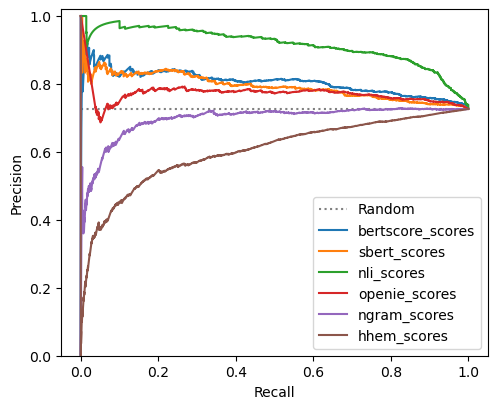

In [16]:
# with human label, Detecting Non-factual
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random') 
plt.plot(Rb1, Pb1, '-', label='bertscore_scores')
plt.plot(Rb2, Pb2, '-', label='sbert_scores')
plt.plot(Rb3, Pb3, '-', label='nli_scores')
plt.plot(Rb4, Pb4, '-', label='openie_scores')
plt.plot(Rb5, Pb5, '-', label='ngram_scores')
plt.plot(Rb6, Pb6, '-', label='hhem_scores')
plt.legend()
plt.ylim(0.0,1.02)
plt.ylabel("Precision")
plt.xlabel("Recall")

## 2. Experiment2: Detect False* (harder/less-trivial)

In [17]:
# with human label, Detecting False
Pb1, Rb1 = get_PR_with_human_labels(bertscore_scores, human_label_detect_False_h, pos_label=1)
Pb2, Rb2 = get_PR_with_human_labels(sbert_scores, human_label_detect_False_h, pos_label=1)
Pb3, Rb3 = get_PR_with_human_labels(nli_scores, human_label_detect_False_h, pos_label=1)
Pb4, Rb4 = get_PR_with_human_labels(openie_scores, human_label_detect_False_h, pos_label=1)
Pb5, Rb5 = get_PR_with_human_labels(ngram_scores, human_label_detect_False_h, pos_label=1)
Pb6, Rb6 = get_PR_with_human_labels(hhem_scores, human_label_detect_False_h, pos_label=1)
print("bertscore_scores")
print_AUC(Pb1, Rb1)
print("-----------------------")
print("sbert_scores")
print_AUC(Pb2, Rb2)
print("-----------------------")
print("nli_scores")
print_AUC(Pb3, Rb3)
print("-----------------------")
print("openie_scores")
print_AUC(Pb4, Rb4)
print("-----------------------")
print("ngram_scores")
print_AUC(Pb5, Rb5)
print("-----------------------")
print("hhem_scores")
print_AUC(Pb6, Rb6)
print("-----------------------")

len: 1577
len: 1577
len: 1577
len: 1577
len: 1577
len: 1577
bertscore_scores
AUC: 42.53
-----------------------
sbert_scores
AUC: 40.27
-----------------------
nli_scores
AUC: 41.98
-----------------------
openie_scores
AUC: 35.21
-----------------------
ngram_scores
AUC: 27.27
-----------------------
hhem_scores
AUC: 23.83
-----------------------


In [18]:
arr = []
for v in human_label_detect_False_h.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.29296131896005073

Text(0.5, 0, 'Recall')

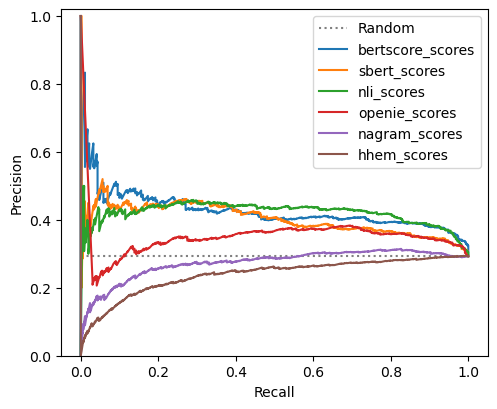

In [19]:
# with human label, Detecting Non-factual
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random') 
plt.plot(Rb1, Pb1, '-', label='bertscore_scores')
plt.plot(Rb2, Pb2, '-', label='sbert_scores')
plt.plot(Rb3, Pb3, '-', label='nli_scores')
plt.plot(Rb4, Pb4, '-', label='openie_scores')
plt.plot(Rb5, Pb5, '-', label='nagram_scores')
plt.plot(Rb6, Pb6, '-', label='hhem_scores')
plt.legend()
plt.ylim(0.0,1.02)
plt.ylabel("Precision")
plt.xlabel("Recall")

# Experiment3: Detecting True

In [20]:
# with human label, Detecting False
Pb1, Rb1 = get_PR_with_human_labels(bertscore_scores, human_label_detect_True, pos_label=1)
Pb2, Rb2 = get_PR_with_human_labels(sbert_scores, human_label_detect_True, pos_label=1)
Pb3, Rb3 = get_PR_with_human_labels(nli_scores, human_label_detect_True, pos_label=1)
Pb4, Rb4 = get_PR_with_human_labels(openie_scores, human_label_detect_True, pos_label=1)
Pb5, Rb5 = get_PR_with_human_labels(ngram_scores, human_label_detect_True, pos_label=1)
Pb6, Rb6 = get_PR_with_human_labels(hhem_scores, human_label_detect_True, pos_label=1)

print("bertscore_scores")
print_AUC(Pb1, Rb1)
print("-----------------------")
print("sbert_scores")
print_AUC(Pb2, Rb2)
print("-----------------------")
print("nli_scores")
print_AUC(Pb3, Rb3)
print("-----------------------")
print("openie_scores")
print_AUC(Pb4, Rb4)
print("-----------------------")
print("ngram_scores")
print_AUC(Pb5, Rb5)
print("-----------------------")
print("hhem_scores")
print_AUC(Pb6, Rb6)
print("-----------------------")

len: 1843
len: 1843
len: 1843
len: 1843
len: 1843
len: 1843
bertscore_scores
AUC: 21.31
-----------------------
sbert_scores
AUC: 22.06
-----------------------
nli_scores
AUC: 16.61
-----------------------
openie_scores
AUC: 25.21
-----------------------
ngram_scores
AUC: 32.00
-----------------------
hhem_scores
AUC: 51.16
-----------------------


In [21]:
arr = []
for v in human_label_detect_True.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.2734671730873576

Text(0.5, 0, 'Recall')

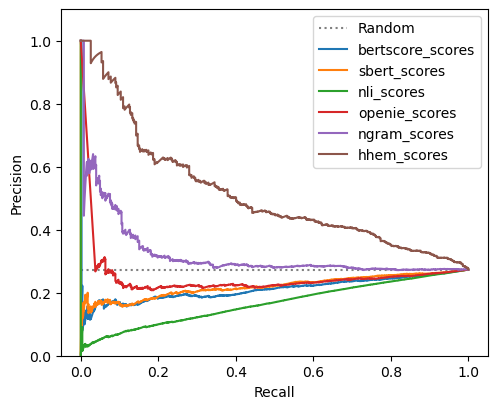

In [26]:
# with human label, Detecting Non-factual
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random') 
plt.plot(Rb1, Pb1, '-', label='bertscore_scores')
plt.plot(Rb2, Pb2, '-', label='sbert_scores')
plt.plot(Rb3, Pb3, '-', label='nli_scores')
plt.plot(Rb4, Pb4, '-', label='openie_scores')
plt.plot(Rb5, Pb5, '-', label='ngram_scores')
plt.plot(Rb6, Pb6, '-', label='hhem_scores')
plt.legend()
plt.ylim(0.0,1.1)
plt.ylabel("Precision")
plt.xlabel("Recall")

# PCC 계산

In [27]:
def get_selfcheck_passage_score_list(data):
    averages = {key: np.mean(values) for key, values in data.items()}
    sorted_averages = [averages[key] for key in sorted(averages)]
    return sorted_averages
#
def get_human_passage_score_list(input_dict):
    # 키를 정렬하고, 정렬된 키에 해당하는 값을 리스트로 추출
    sorted_values = [input_dict[key] for key in sorted(input_dict)]
    return sorted_values

def plot_scatter_and_regression(selfcheck_method_name, selfcheck_passage_scores):
    plt.scatter(human_passage_scores, selfcheck_passage_scores, alpha=0.5, color='gray')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(human_passage_scores, selfcheck_passage_scores)
    line_x = np.array([min(human_passage_scores), max(human_passage_scores)])
    line_y = slope * line_x + intercept
    plt.plot(line_x, line_y, 'r-', label=f'y={slope:.2f}x+{intercept:.2f}')

    plt.title(f'Scatter Plot with Regression Line for {selfcheck_method_name}')
    plt.xlabel('Human Score (0=Factual, +1=Non-Factual)')
    plt.ylabel('Method Score')
    plt.legend()
    
    plt.show()

In [28]:
human_passage_scores = get_human_passage_score_list(passage_human_label_detect_scores)
bertscore_passage_scores = get_selfcheck_passage_score_list(bertscore_scores)
sbert_passage_scores=get_selfcheck_passage_score_list(sbert_scores)
nli_passage_scores = get_selfcheck_passage_score_list(nli_scores)
openie_passage_scores=get_selfcheck_passage_score_list(openie_scores)
ngram_passage_scores=get_selfcheck_passage_score_list(ngram_scores)
hhem_passage_scores=get_selfcheck_passage_score_list(hhem_scores)


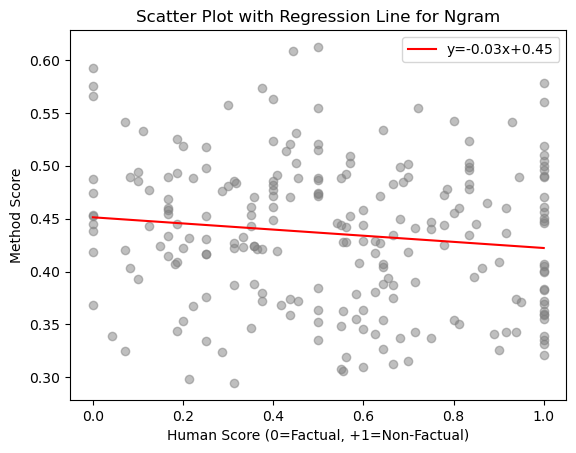

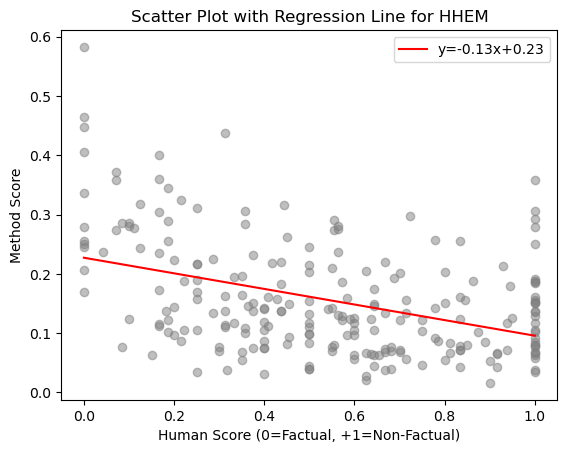

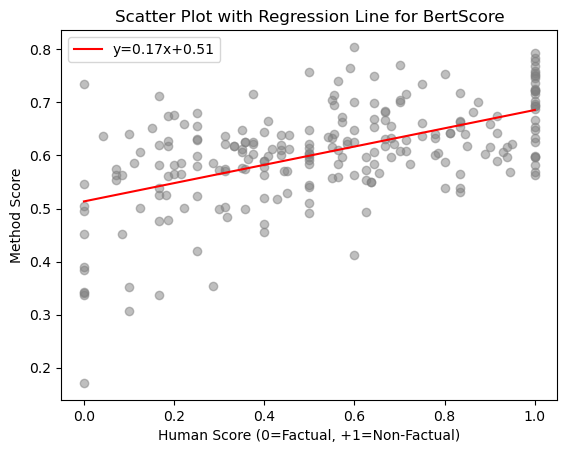

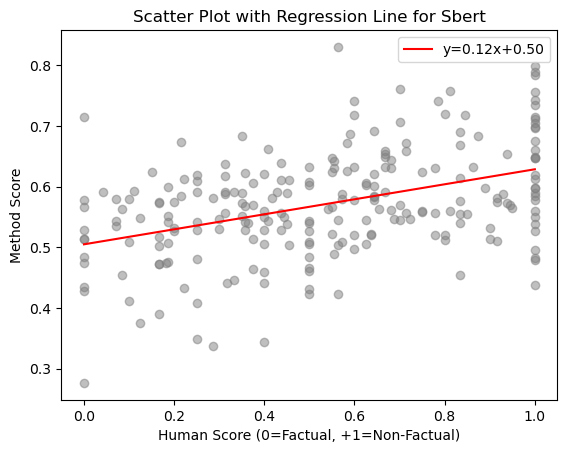

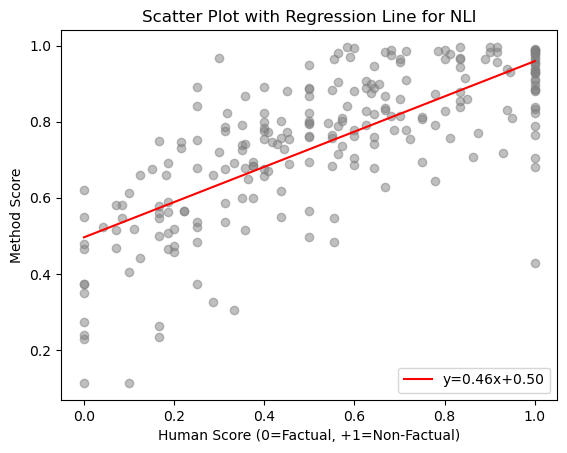

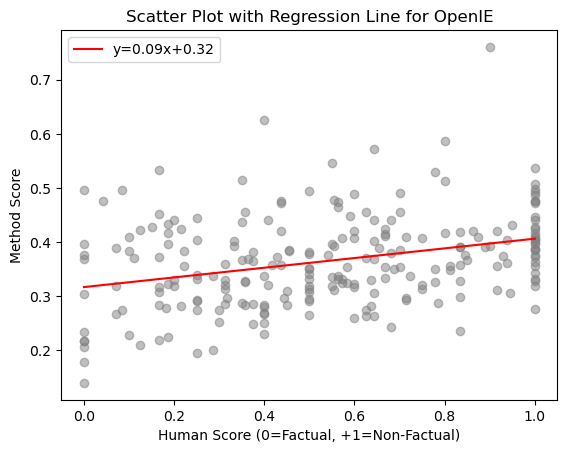

In [29]:
# 함수 호출 예시
plot_scatter_and_regression('Ngram', ngram_passage_scores)
plot_scatter_and_regression('HHEM', hhem_passage_scores)
plot_scatter_and_regression('BertScore', bertscore_passage_scores)
plot_scatter_and_regression('Sbert', sbert_passage_scores)
plot_scatter_and_regression('NLI', nli_passage_scores)
plot_scatter_and_regression('OpenIE', openie_passage_scores)

In [30]:
import pickle

# 파일에서 bertscore_scores, sbert_scores, nli_scores, openie_scores를 로드
with open('bertscore_scores.pkl', 'rb') as f:
    bertscore_scores1 = pickle.load(f)

with open('sbert_scores.pkl', 'rb') as f:
    sbert_scores1 = pickle.load(f)

with open('nli_scores.pkl', 'rb') as f:
    nli_scores1 = pickle.load(f)

with open('openie_scores.pkl', 'rb') as f:
    openie_scores1 = pickle.load(f)

In [31]:
# with human label, Detecting False
Pb1, Rb1 = get_PR_with_human_labels(bertscore_scores1, human_label_detect_False, pos_label=1)
Pb2, Rb2 = get_PR_with_human_labels(sbert_scores1, human_label_detect_False, pos_label=1)
Pb3, Rb3 = get_PR_with_human_labels(nli_scores1, human_label_detect_False, pos_label=1)
Pb4, Rb4 = get_PR_with_human_labels(openie_scores1, human_label_detect_False, pos_label=1)

print("bertscore_scores")
print_AUC(Pb1, Rb1)
print("-----------------------")
print("sbert_scores")
print_AUC(Pb2, Rb2)
print("-----------------------")
print("nli_scores")
print_AUC(Pb3, Rb3)
print("-----------------------")
print("openie_scores")
print_AUC(Pb4, Rb4)
print("-----------------------")
print("ngram_scores")
print_AUC(Pb5, Rb5)
print("-----------------------")
print("hhem_scores")
print_AUC(Pb6, Rb6)
print("-----------------------")

len: 1843
len: 1843
len: 1843
len: 1843
bertscore_scores
AUC: 80.49
-----------------------
sbert_scores
AUC: 79.28
-----------------------
nli_scores
AUC: 91.60
-----------------------
openie_scores
AUC: 77.14
-----------------------
ngram_scores
AUC: 32.00
-----------------------
hhem_scores
AUC: 51.16
-----------------------
